# Enzyme Kinetic Parameter Inference
> Supposing you observe a timeseries of concentrations of metabolites, can you infer the kinetic parameters for the enzyme? 

- hide: true


In [23]:
#collapse
# imports
from itertools import combinations_with_replacement, product
from collections import Counter
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import to_hex
import scipy.stats
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d
from scipy.stats.kde import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import Matern

import ipywidgets as widgets
from IPython.display import display
            
%config InlineBackend.figure_format = 'retina'

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 140
plt.rcParams['agg.path.chunksize'] = 10000

exp = np.exp
sqrt = np.sqrt
Π = np.prod
π = np.pi
N = np.random.normal

In [2]:
#collapse
# simple matrix view macro
import PIL.Image
from matplotlib.pyplot import imshow
def show(*Ms): 
    fig, axs = plt.subplots(ncols=len(Ms))
    for M, ax in zip(Ms, (axs if type(axs) == list else [axs])):
        M = np.atleast_2d(M)
        ax.imshow(PIL.Image.fromarray((M - M.min()) * 255 / M.max()))
        ax.set_xticks([0, M.shape[1]])
        ax.set_yticks([0, M.shape[0]])
        for side in ["right","top","bottom","left"]:
            ax.spines[side].set_visible(False)
    return fig, axs

In [3]:
#collapse
# simple distrib pdf view macro
from scipy.stats import weibull_min, dweibull, dgamma, expon as exponential
from scipy.stats import rv_discrete, rv_continuous

def is_discrete(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_discrete)
    else: return isinstance(dist, rv_discrete)

def is_continuous(dist):

    if hasattr(dist, 'dist'):
        return isinstance(dist.dist, rv_continuous)
    else: return isinstance(dist, rv_continuous)

def plot_distrib(distrib, title=None):
        
    fig, ax = plt.subplots(1, 1)
    
    if is_continuous(distrib):
        x = np.linspace(distrib.ppf(0.01),
                        distrib.ppf(0.99), 100)       
        ax.plot(x, distrib.pdf(x), 'k-', lw=0.4)
    
    elif is_discrete(distrib):
        x = np.arange(distrib.ppf(0.01),
                      distrib.ppf(0.99))
        ax.plot(x, distrib.pmf(x), 'bo', ms=2, lw=0.4)

    r = distrib.rvs(size=1000)
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=100)

    if title: ax.set_title(title)
    return ax
    

## 1. Background

$$\newcommand{\kon}{k_{\mathrm{on}}}
\newcommand{\koff}{k_{\mathrm{off}}}
\newcommand{\kcat}{k_{\mathrm{cat}}}
\newcommand{\kuncat}{k_{\mathrm{uncat}}}
\newcommand{\dSdt}{\frac{d[\mathrm{S}]}{dt}}
\newcommand{\dEdt}{\frac{d[\mathrm{E}]}{dt}}
\newcommand{\dESdt}{\frac{d[\mathrm{ES}]}{dt}}
\newcommand{\dPdt}{\frac{d[\mathrm{P}]}{dt}}$$
### 1.1 Enzyme Kinetics
Enzymes catalyze many critical chemical reactions in cells. 

Describing a cell with a mathematical model (a long-standing goal of computational biologists) would entail modelling each enzyme-catalyzed chemical reaction. 

However, although we may know the _scheme_ for many enzymatic reactions (the responsible enzyme, the associated substrates, and resultant products) we are often missing many of the details needed to construct a faithful mathematical model of the reaction. 

Let's begin by introducing the mathematical model used to describe enzymatic reaction schemes. Consider the following enzymatically-catalyzed (uni uni) chemical reaction scheme:

$$ E+S \underset{\koff}{\overset{\kon}{\rightleftarrows}} ES \underset{\kuncat}{\overset{\kcat}{\rightleftarrows}}E+P $$

In this scheme E is an enzyme, S is its substrate, ES is the enzyme-substrate complex, which is an intermediate, and P is the product of the reaction. Each of those chemical species has a concentration in a fixed volume, which we denote with brackets (e.g. $[\mathrm{E}]$ = enzyme concentration). 

If we make the simplifying assumption that the 4 molecular species are 'well-mixed' in solution, we can invoke the '[Law of Mass Action](https://en.wikipedia.org/wiki/Law_of_mass_action)' under which the rate of each of the four included reactions is linear in the concentrations of the reactants (with an associated coefficient called the rate constant). The reactions in the above scheme are: enzyme-substrate association ($\kon$), dissociation ($\koff$), enzyme catalysis of substrate into product ($\kcat$), and enzyme-product re-association ("uncatalysis", $\kuncat$). The 'direction' of the reaction, and the designation of 'substrate' and 'product' is our choice -- the model is entirely symmetric, which is reflected in the associated ODEs:

$$\begin{aligned}
    \frac{d[\mathrm{S}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] \\
    \frac{d[\mathrm{E}]}{dt} &= k_{\mathrm{off}}[\mathrm{ES}] - k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] + k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{ES}]}{dt} &= - k_{\mathrm{off}}[\mathrm{ES}] + k_{\mathrm{on}}[\mathrm{E}][\mathrm{S}] - k_{\mathrm{cat}}[\mathrm{ES}] + k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] \\
    \frac{d[\mathrm{P}]}{dt} &= k_{\mathrm{cat}}[\mathrm{ES}] - k_{\mathrm{uncat}}[\mathrm{E}][\mathrm{P}] 
\end{aligned}$$

This differential equation model describing the (deterministic) chemical kinetics for an enzymatically-catalyzed reaction in well-mixed conditions contains 4 kinetic parameters, i.e. 4 degrees of freedom, which we do not know _a priori_. These will be the subject of inference.

> Note: the intracellular environment is not best described as well-mixed, and models of '[Macromolecular Crowding](https://en.wikipedia.org/wiki/Macromolecular_crowding)' have led to more accurate rate laws for these reactions _in vivo_. However, we will retain the well-mixed assumption for now.

### 1.2 Parameter Inference

There are 3 typical problems associated with ODE models:

- Supplied with a complete specification of the system, the **forward problem** is to integrate the differential equations from some initial conditions forwards in time and predict the trajectory of the system. This is what is typically meant by "solving" the ODE system, but exact analytical solutions are rare, and [numerical methods](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) are often brought to bear to approximate system trajectories.
- Supplied with one or more trajectories (data) but incomplete specification of the system, the **inverse problem** is to estimate parameters of the system (coefficients in the ODE expressions). 
- Finally, given some manipulable inputs, the **control problem** is to drive the system towards some desired state.

This post will explore a range of approaches for the inverse problem. Our goal will be to estimate the kinetic parameters of enzymatically-catalyzed chemical reactions from timeseries of concentrations of the molecular species. 

> Note: enzyme kinetic parameters are typically not inferred from metabolite timeseries data using the methods we will describe, but instead from specific [enzyme assays](https://en.wikipedia.org/wiki/Enzyme_assay). However, at the moment, these assays are limited to studying one enzyme at a time. The inference approaches described in this post can leverage data from emerging high-throughput assays. 


The determination of the kinetic parameters for the enzymatic reactions of life is a major project, and reported values have been tabulated in databases such as [BRENDA](https://www.brenda-enzymes.org/). However, my experience with these databases has been that the reported kinetic parameters appear to be severely unreliable. 


### 1.3 The Michaelis-Menten/Briggs-Haldane Approximation

Two assumptions commonly made at this point are:
1. to assume the initial substrate concentration is much larger than the enzyme concentration ($[\mathrm{S_0}] \gg [\mathrm{E_0}]$). 
2. to suppose that the rates of enzyme-substrate association ($\kon$) and dissociation ($\koff$) are greater than the rates of catalysis and uncatalysis (i.e. $\kon$, $\koff$ $\gg$ $\kcat$, $\kuncat$). 


These assumptions permit a [timescale separation argument](http://www.bio-physics.at/wiki/index.php?title=Separation_of_Timescales) called the "Quasi-Steady-State Approximation" (QSSA) permits us to set $\dESdt = 0$. From this approximation, we can [derive](http://www.bio-physics.at/wiki/index.php?title=Reversible_Michaelis_Menten_Kinetics) the traditional Reversible Michaelis-Menten/Briggs-Haldane expression:

$$\begin{aligned}
\frac{d[\mathrm{P}]}{dt} &= 
\frac{
\frac{\kcat \, [\mathrm{E_T}] [\mathrm{S}]}{K_{m,\mathrm{S}}} - 
\frac{\koff \, [\mathrm{E_T}] [\mathrm{P}]}{K_{m,\mathrm{P}}}}
{1+\frac{[\mathrm{S}]}{K_{m,\mathrm{S}}} + \frac{[\mathrm{P}]}{K_{m,\mathrm{P}}}} \\ \\
\frac{d[\mathrm{S}]}{dt} &= -\frac{d[\mathrm{P}]}{dt}
\end{aligned}$$

in which we have introduced the "Michaelis Constants": $K_{m,\mathrm{S}} = \frac{\koff + \kcat}{\kon}$ and $K_{m,\mathrm{P}} = \frac{\kcat + \koff}{\kuncat}$. 

The QSSA reduces the system from 4 variables to 2. There are still 4 kinetic parameters to estimate in this reduced model. 

> Note: _another_ assumption typically made at this point is to assume that catalysis is irreversible ($\kuncat = 0$), leading to a further simplified expression for the rate of product formation $\frac{d[\mathrm{P}]}{dt}$. However, this assumption is quite often inaccurate, so we will not make it. 

## 2. Exploring the Forward Model

### 2.1 A Standard Example

Before we explore techniques to estimate enzyme kinetic parameters from timeseries data, we need to generate timeseries data to begin with. We can accomplish that by fixing kinetic parameters, then solving the forward problem. It will turn out that integrating the model forwards is a subroutine of both approaches to the inverse problem we'll see in this post.

In order to produce a trajectory, we need to set **initial conditions**. We'll integrate the reaction kinetics of a hypothetical _in vitro_ experiment, in which a fixed quantity of enzyme and substrate are added to the reaction at the outset, then left to react. 

> Note:  _in vivo_ we would expect the concetration of enzyme to vary over time, and the substrate to be replenished. We will generalize this approach to a more biologically-relevant setting in a future post.  


Our initial conditions are:

- $[E]_0$, the initial enzyme concentration, is set to 1mM (miliMolar, i.e. 1000μM). 
- $[S]_0$, the initial substrate concentration is set to 10mM.  

In [63]:
default_initial_conditions = {
    'E_0': 1e3,
    'S_0': 10e3
}

Next, let's fix some generic rate constants:
- $\kon \,$  of $10^6$ events per Mol per second, or 1 per μM per second, is a typical rate for enzyme-substrate binding.
- $\koff \,$  of 500/s results in a $\koff$/$\kon$ = $k_d$ of 500 μM, which is a typical $k_d$.
- $\kcat \,$  is 30/s, a fairly slow but respectable $\kcat$.
- $\kuncat \,$  of $\frac{\kon}{10}$ is often considered as the boundary for the QSSA to hold (so 0.1 per μM per second). Let's use $\kuncat = \frac{\kon}{100} = $ 0.01/μM for good measure.

Our units are μM and seconds. 

In [6]:
# Set default kinetic parameters
default_kinetic_params = {
    'k_on': 1,
    'k_off': 500,
    'k_cat': 30,
    'k_uncat': 0.01
}

def k_ms(p): return (p['k_off'] + p['k_cat']) / p['k_on']
def k_mp(p): return (p['k_off'] + p['k_cat']) / p['k_uncat']

default_kinetic_params['k_ms'] = k_ms(default_kinetic_params)
default_kinetic_params['k_mp'] = k_mp(default_kinetic_params)


There are a variety of numerical methods to integrate systems of differential equations. The most straightforward is [Euler's method](https://en.wikipedia.org/wiki/Euler_method), which we've written down explicitly for this system below: 

In [14]:
#collapse
# define euler_full(), which integrates the full kinetics with Euler's Method, and returns a trajectory
def euler_full(dt, steps, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):
    
    S = S_0
    E = E_0
    ES = 0
    P = 0
    traj = [[S, E, ES, P]]
    
    for _ in range(int(steps)):
        
        dS = k_off * ES - k_on * E * S
        dE = k_off * ES - k_on * E * S + k_cat * ES - k_uncat * E * P
        dES = k_on * E * S - k_off * ES - k_cat * ES + k_uncat * E * P
        dP = k_cat * ES - k_uncat * E * P
        
        S += dS * dt
        E += dE * dt
        ES += dES * dt
        P += dP * dt
    
        traj.append([S, E, ES, P])
    
    return pd.DataFrame(traj, columns=['S', 'E', 'ES', 'P'], index=np.around(np.linspace(0, dt*steps, int(steps)+1), 6))

We'll also write down Euler's method for the Michaelis-Menten/Briggs-Haldane kinetics

In [11]:
#collapse
# define euler_MM(), which integrates the Michaelis-Menten/Briggs-Haldane kinetics
def euler_MM(dt, steps, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):
            
    S = S_0
    E = E_0
    P = 0
    traj = [P]
    
    for _ in range(int(steps)):
        
        dP = ((k_cat * E * S) / k_ms - (k_off * E * P) / k_mp) / (1 + S / k_ms + P / k_mp)        
        dS = -dP
        
        P += dP * dt
        S += dS * dt
    
        traj.append(P)
    
    return pd.Series(traj, name='P_MM', index=np.around(np.linspace(0, dt*steps, int(steps)+1), 6)).to_frame()

To simulate the kinetics with little derivative steps, we need a step size, and a number of total steps:

In [134]:
dt = 1e-6
steps = 5e5

Now we can integrate the reaction kinetics, and plot the trajectory. We'll overlay the Michaelis-Menten/Briggs-Haldane kinetics with dotted lines on top of the full kinetics (solid). 

In [15]:
default_traj_full = euler_full(dt, steps, **default_kinetic_params, **default_initial_conditions)
default_traj_mm = euler_MM(dt, steps, **default_kinetic_params, **default_initial_conditions)

In [19]:
#collapse
# figure styles
def fig_style(ax):
    for side in ["right","top"]: ax.spines[side].set_visible(False)
    ax.set_xlabel('time (s)',  weight='bold')
    ax.set_ylabel('concentration (μM)',  weight='bold')
    
def param_string(E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None): 
    return f'[k_on= {k_on}/μM/s]   [k_off = {k_off}/s]   [k_cat = {k_cat}/s]   [k_uncat = {k_uncat}/μM/s]   [E₀ = {int(E_0)}μM]   [S₀ = {int(S_0)}μM]'

c = {
    'S': 'dodgerblue',
    'E': 'sienna', 
    'ES': 'blue', 
    'P': 'darkblue',
    'S_MM': 'steelblue',
    'P_MM': 'slateblue'}

c = {k:to_hex(v) for k,v in c.items()}

def color(columns): return [c[col] for col in columns]

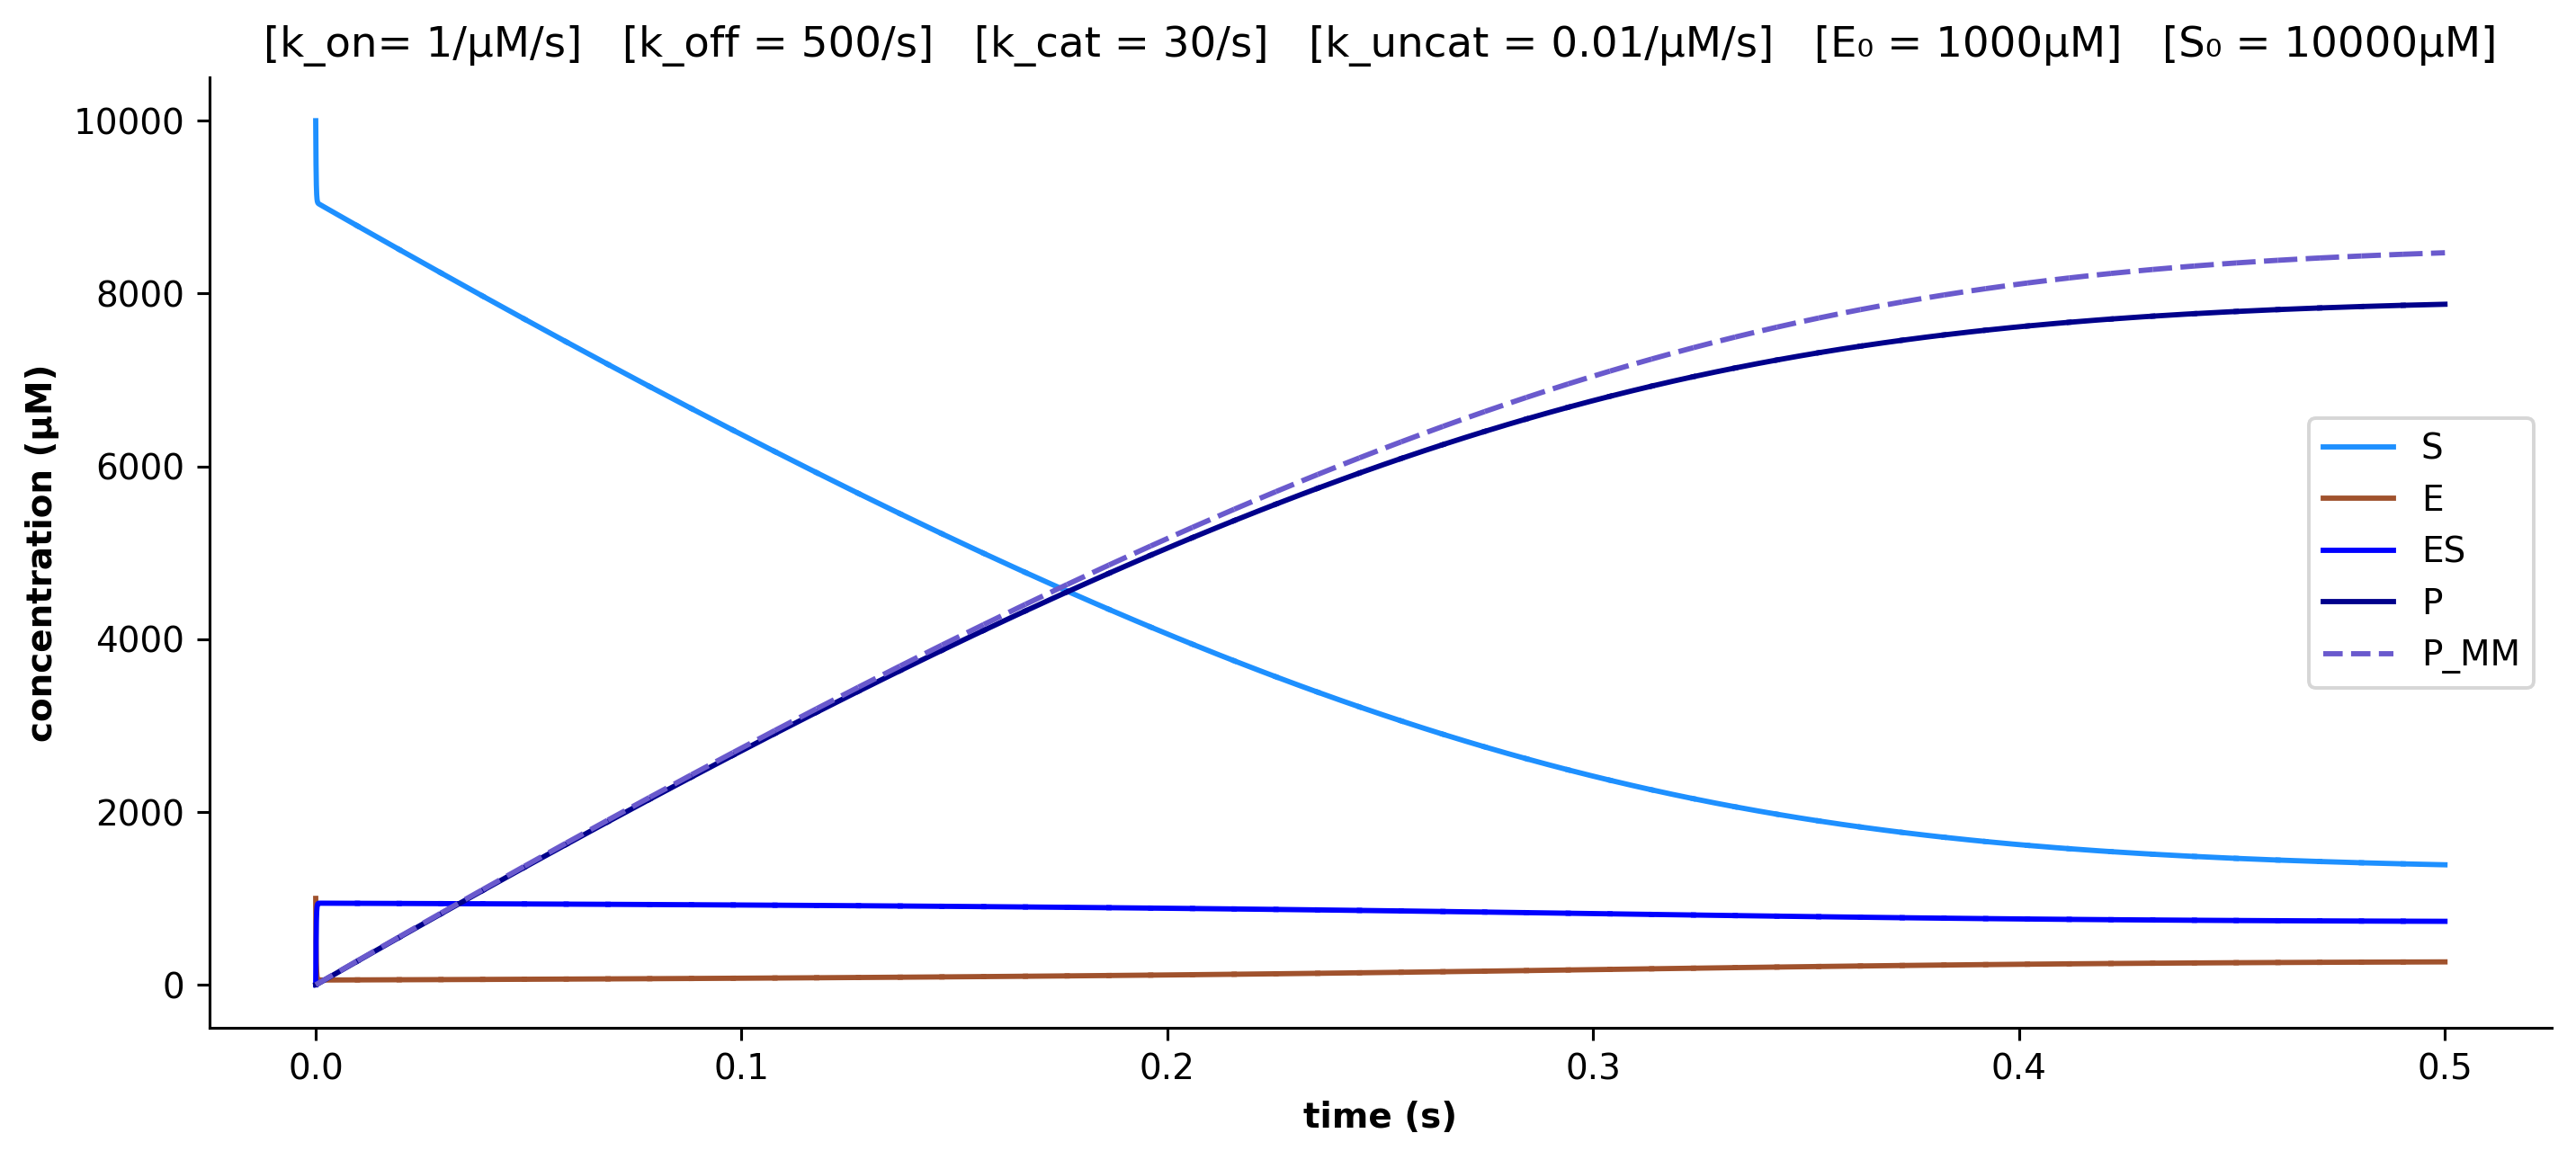

In [22]:
ax = default_traj_full.plot.line(title=param_string(**default_initial_conditions, **default_kinetic_params), color=color(default_traj_full.columns))
default_traj_mm.plot.line(ax=ax, color=color(default_traj_mm.columns), linestyle='--')

fig_style(ax)

We can plainly see the validity of the Quasi-Steady-State Approximation (QSSA) in action in the trajectory: <span style='color:#a0522d'>Enzyme E</span> and <span style='color:#1e90ff'>Substrate S</span> rapidly form <span style='color:#0000ff'>Enzyme-Substrate complex ES</span>, the concentration of which remains relatively constant throughout the course of the reaction (recall the QSSA is the approximation that $\dESdt = 0$). Thus, the Michaelis-Menten/Briggs-Haldane product concentration trajectory <span style='color:#6a5acd'><b>P_MM</b></span> well approximates the full kinetics trajectory for the concentration of <span style='color:#00008b'>product <b>P</b></span>, since the requisite assumptions are valid, namely, (1) $[\mathrm{S_0}] \gg [\mathrm{E_0}]$ and (2) $\kon$, $\koff$ $\gg$ $\kcat$, $\kuncat$. 

In practice, Michaelis-Menten/Briggs-Haldane kinetics are often assumed by default, risking the possibility of their misapplication. Let's take this opportunity to explore how the MM/BH kinetics diverge from the full kinetics when we violate the requisite assumptions. 

### 2.2: Breaking the Michaelis-Menten/Briggs-Haldane Assumptions: <br /> &nbsp; &nbsp; &nbsp; Initial Substrate:Enzyme Ratio

Suppose first the number of molecules of substrate is _not_ much greater than the number of molecules of enzyme, which is a plausible regime for certain reactions _in vivo_. 

In [75]:
# Set initial enzyme and substrate concentrations: 2 molecules of substrate for each molecule of enzyme.
initital_conditions = {
    'E_0': 1e3,
    'S_0': 2e3
}

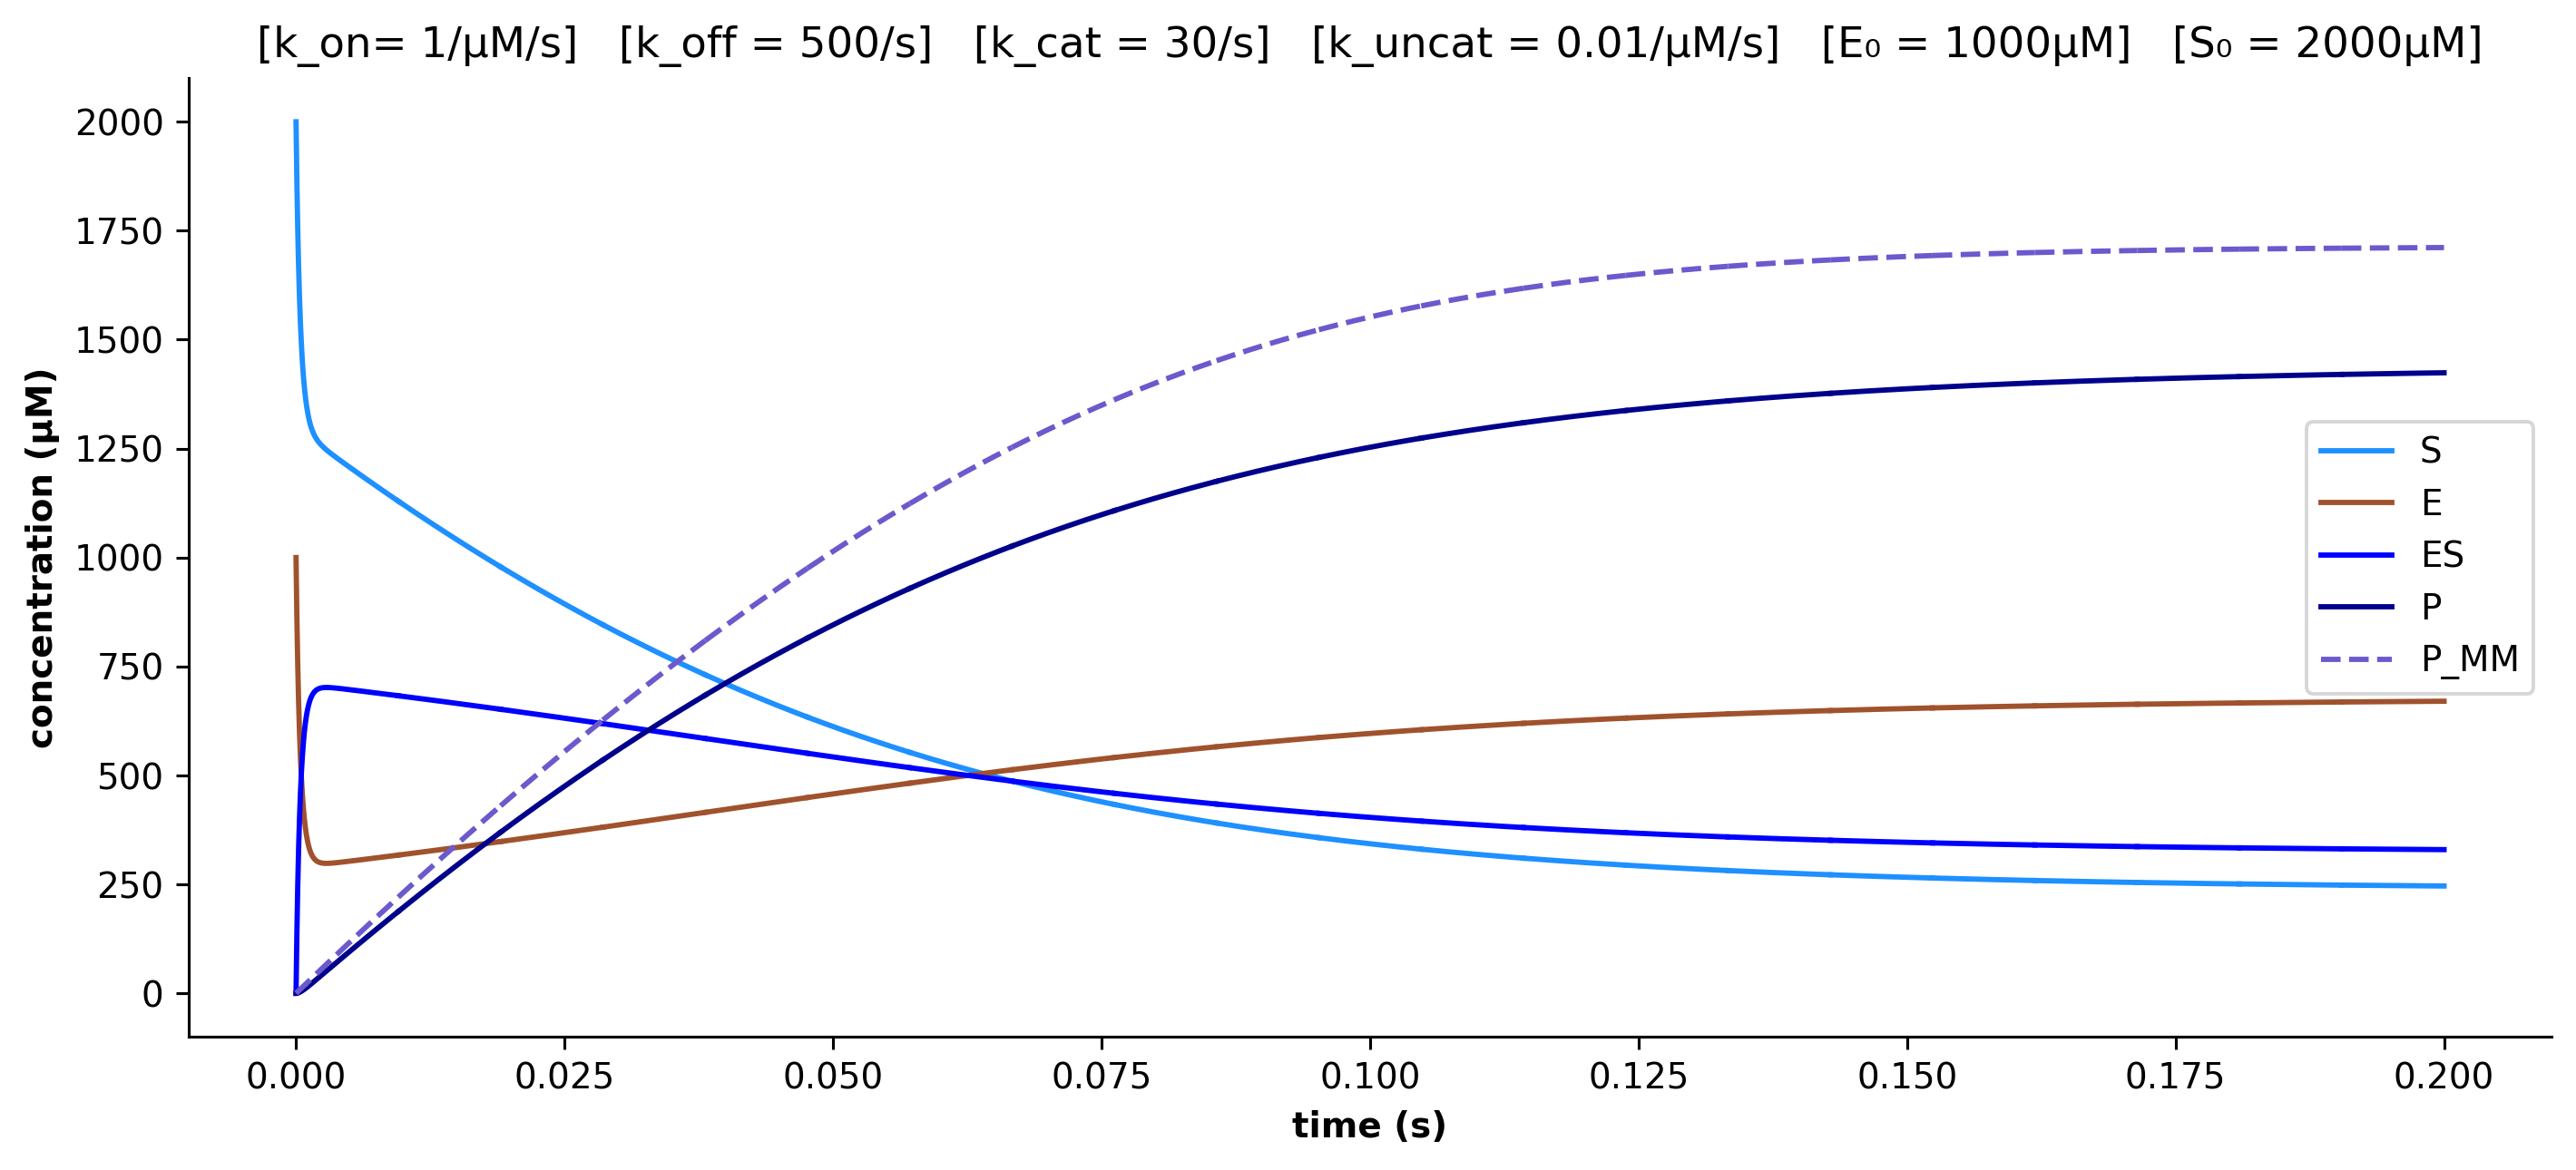

In [55]:
#collapse
traj_full = euler_full(dt, 2e5, **initital_conditions, **default_kinetic_params)
traj_mm = euler_MM(dt, 2e5, **initital_conditions, **default_kinetic_params)

ax = traj_full.plot.line(title=param_string(**initital_conditions, **default_kinetic_params), color=color(traj_full.columns))
traj_mm.plot.line(ax=ax, color=color(traj_mm.columns), linestyle='--')

fig_style(ax)

Then <span style='color:#6a5acd'><b>P_MM</b></span> worsens significantly as an estimate of <span style='color:#00008b'><b>P</b></span>.


### 2.3: Breaking the Michaelis-Menten/Briggs-Haldane Assumptions: <br /> &nbsp; &nbsp; &nbsp; Fast Enzyme-Substrate Complex Kinetics

Suppose further that the rates of association and dissociation of enzyme with subtstrate are _not_ substantially faster than those of enzyme and product. 

In [143]:
kinetic_params = {
    'k_on': 0.05,
    'k_off': 1,
    'k_cat': 50,
    'k_uncat': 0.5
}

kinetic_params['k_ms'] = k_ms(kinetic_params)
kinetic_params['k_mp'] = k_mp(kinetic_params)

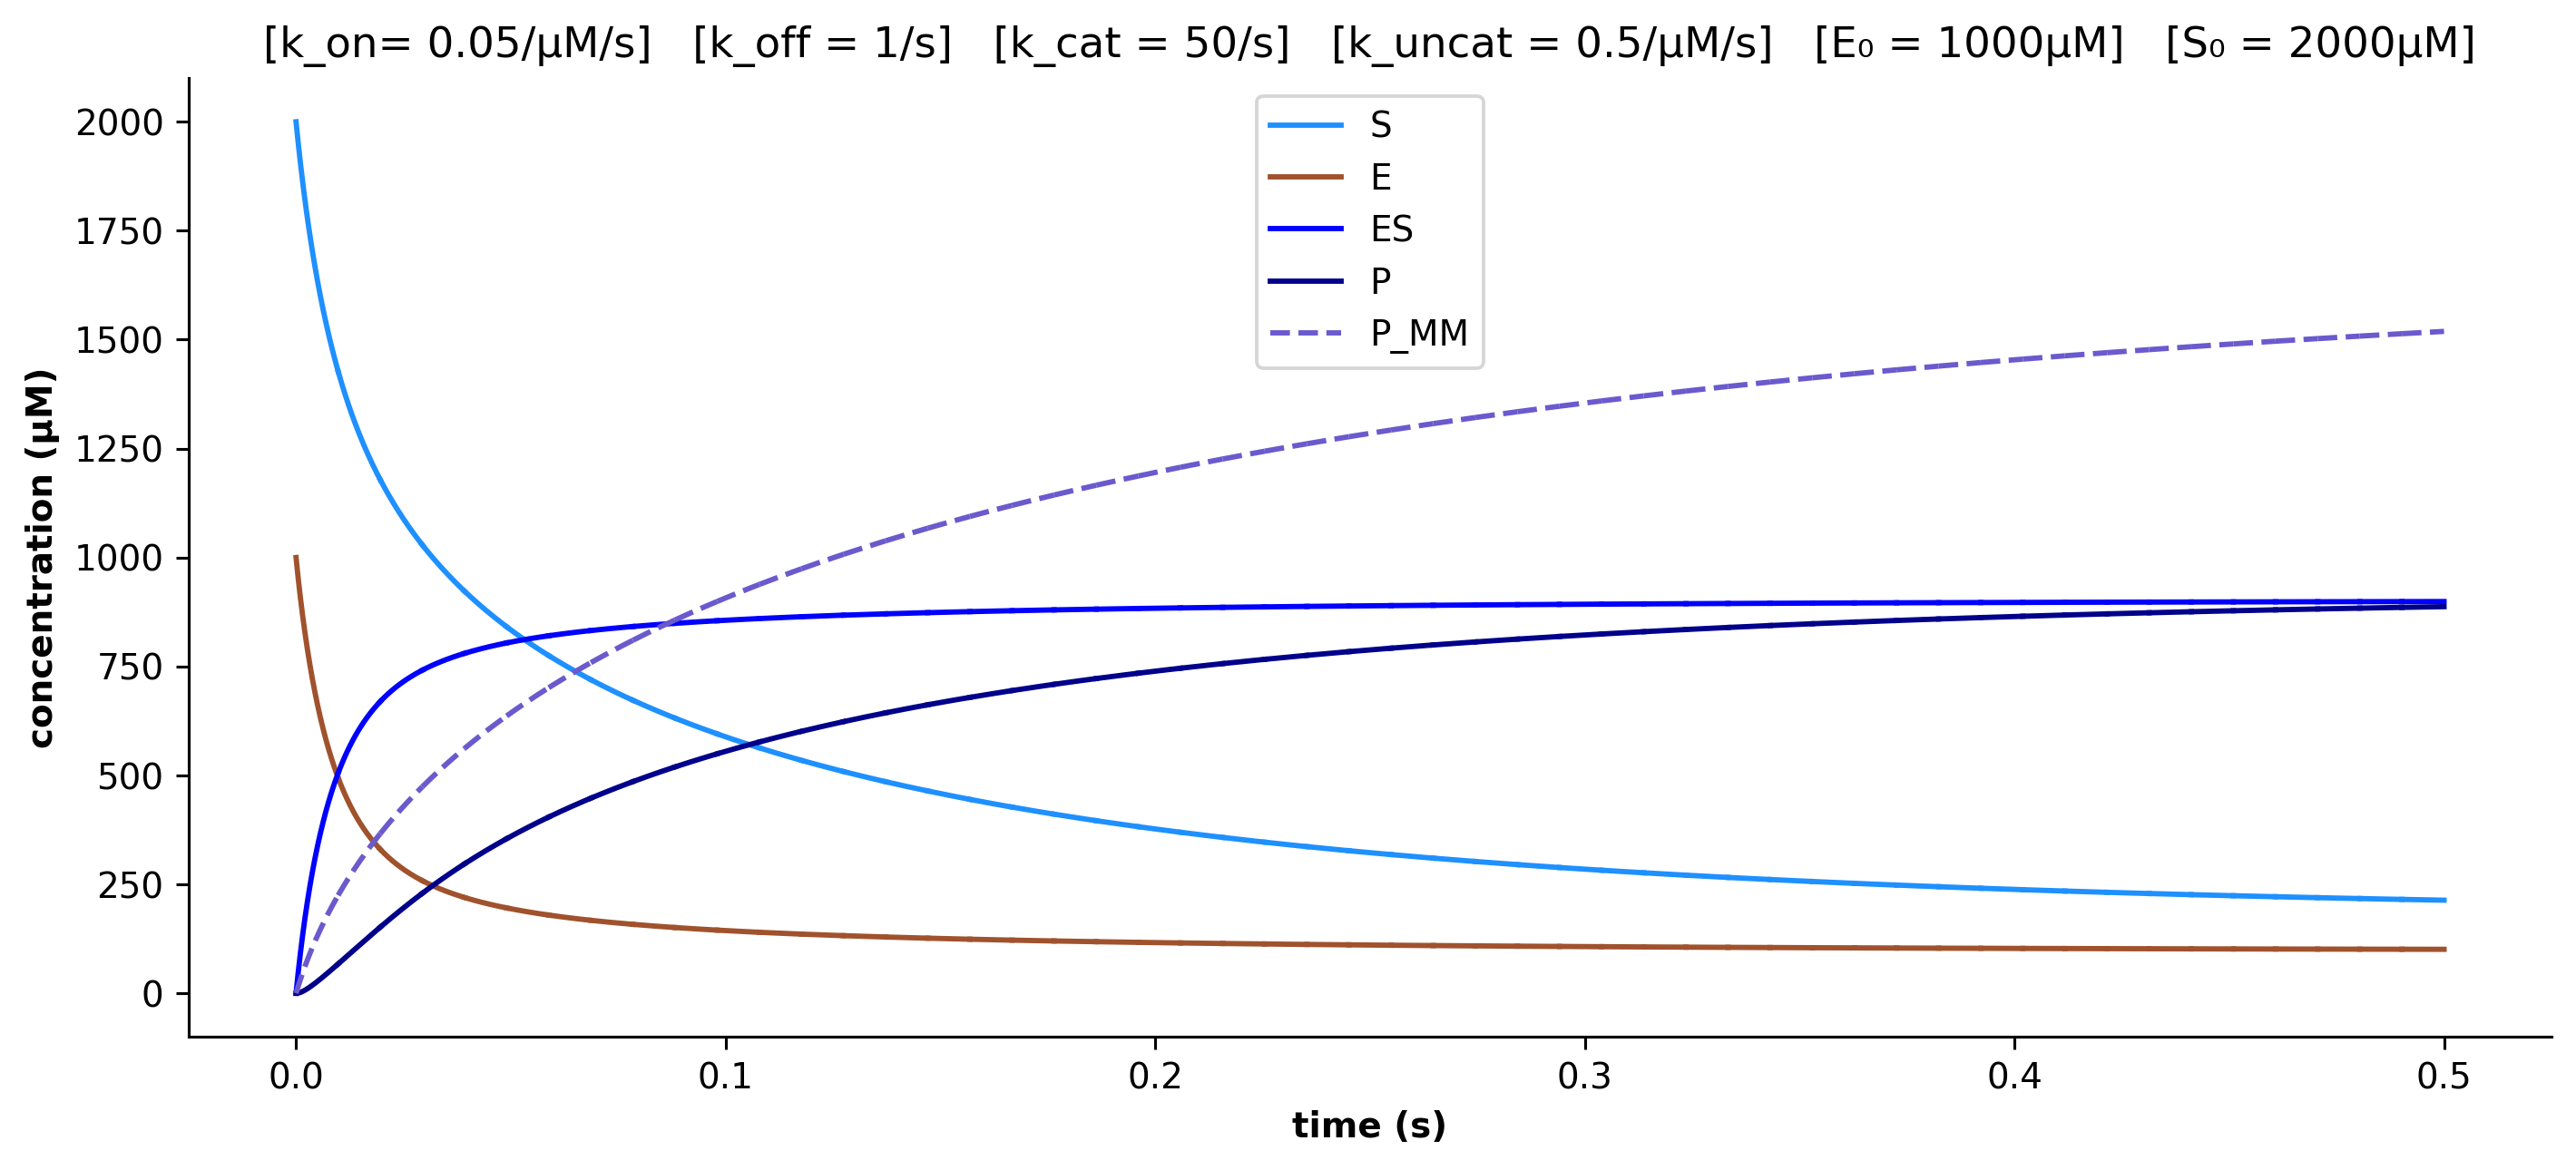

In [144]:
#collapse
traj_full = euler_full(dt, steps, **initital_conditions, **kinetic_params)
traj_mm = euler_MM(dt, steps, **initital_conditions, **kinetic_params)

ax = traj_full.plot.line(title=param_string(**initital_conditions, **kinetic_params), color=color(traj_full.columns))
traj_mm.plot.line(ax=ax, color=color(traj_mm.columns), linestyle='--')

fig_style(ax)

Then the Michaelis-Menten/Briggs-Haldane kinetics diverge further.

In each of these latter trajectories, the criteria to make the Michaelis-Menten/Briggs-Haldane approximation are violated, leading to poor approximations to the full kinetics. We belabor this point here because in the following, we will seek to infer the parameters of the kinetics, and our inference will fit poorly if we fit to inappropriate kinetic expressions.

### 2.4: Comparing Integrators

All of the above trajectories are generated by Euler's Method, the most intuitive ODE integration technique. Unfortunately, Euler's Method's naïvete has drawbacks: 
- The size of the error is large
- It's slow, due to the uniform size of the timesteps.

A popular alternative which reconciles these drawbacks is the 4th order [Runge Kutta Method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (abbreviated RK4) which is the default integration method of scipy's [`integrate`](https://docs.scipy.org/doc/scipy/reference/integrate.html) package. 

Due to it's superior speed and accuracy, we'll use this method during inference. As a sanity check, we compare our Euler Method code to scipy's RK4:


In [137]:
#collapse
# define scipy_full and scipy_MM functions (and helpers) to integrate chemical kinetics with RK4
from scipy.integrate import solve_ivp

def dy_full(t, y, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):
    # Y ordered S,E,ES,P
    dy = [0]*4
    dy[0] = k_off * y[2] - k_on * y[1] * y[0]
    dy[1] = k_off * y[2] - k_on * y[1] * y[0] + k_cat * y[2] - k_uncat * y[1] * y[3]
    dy[2] = k_on * y[1] * y[0] - k_off * y[2] - k_cat * y[2] + k_uncat * y[1] * y[3]
    dy[3] = k_cat * y[2] - k_uncat * y[1] * y[3]    

    return dy


def dy_MM(t, y, E_0=None, S_0=None, k_on=None, k_off=None, k_cat=None, k_uncat=None, k_ms=None, k_mp=None):
    # Y ordered S,P
    dy = [0]*2
    dy[1] = ((k_cat * E_0 * y[0]) / k_ms - (k_off * E_0 * y[1]) / k_mp) / (1 + y[0] / k_ms + y[1] / k_mp)        
    dy[0] = -dy[1]
    
    return dy


def scipy_full(dt, steps, kinetic_params, E_0=None, S_0=None):

    t = np.linspace(0,dt*steps,1001)
    t_span = (t[0], t[-1])
    y0 = [S_0, E_0, 0, 0]

    sol = solve_ivp(lambda t,y: dy_full(t,y, E_0=E_0, S_0=S_0, **kinetic_params), t_span, y0, first_step=dt)

    return pd.DataFrame(sol.y.T, index=sol.t, columns=['S', 'E', 'ES', 'P'])


def scipy_MM(dt, steps, kinetic_params, E_0=None, S_0=None):

    t = np.linspace(0,dt*steps,1001)
    t_span = (t[0], t[-1])
    y0 = [S_0, 0]

    sol = solve_ivp(lambda t,y: dy_MM(t,y, E_0=E_0, S_0=S_0, **kinetic_params), t_span, y0, first_step=dt)
    
    return pd.DataFrame(sol.y.T, index=sol.t, columns=['S', 'P'])['P'].rename('P_MM').to_frame()


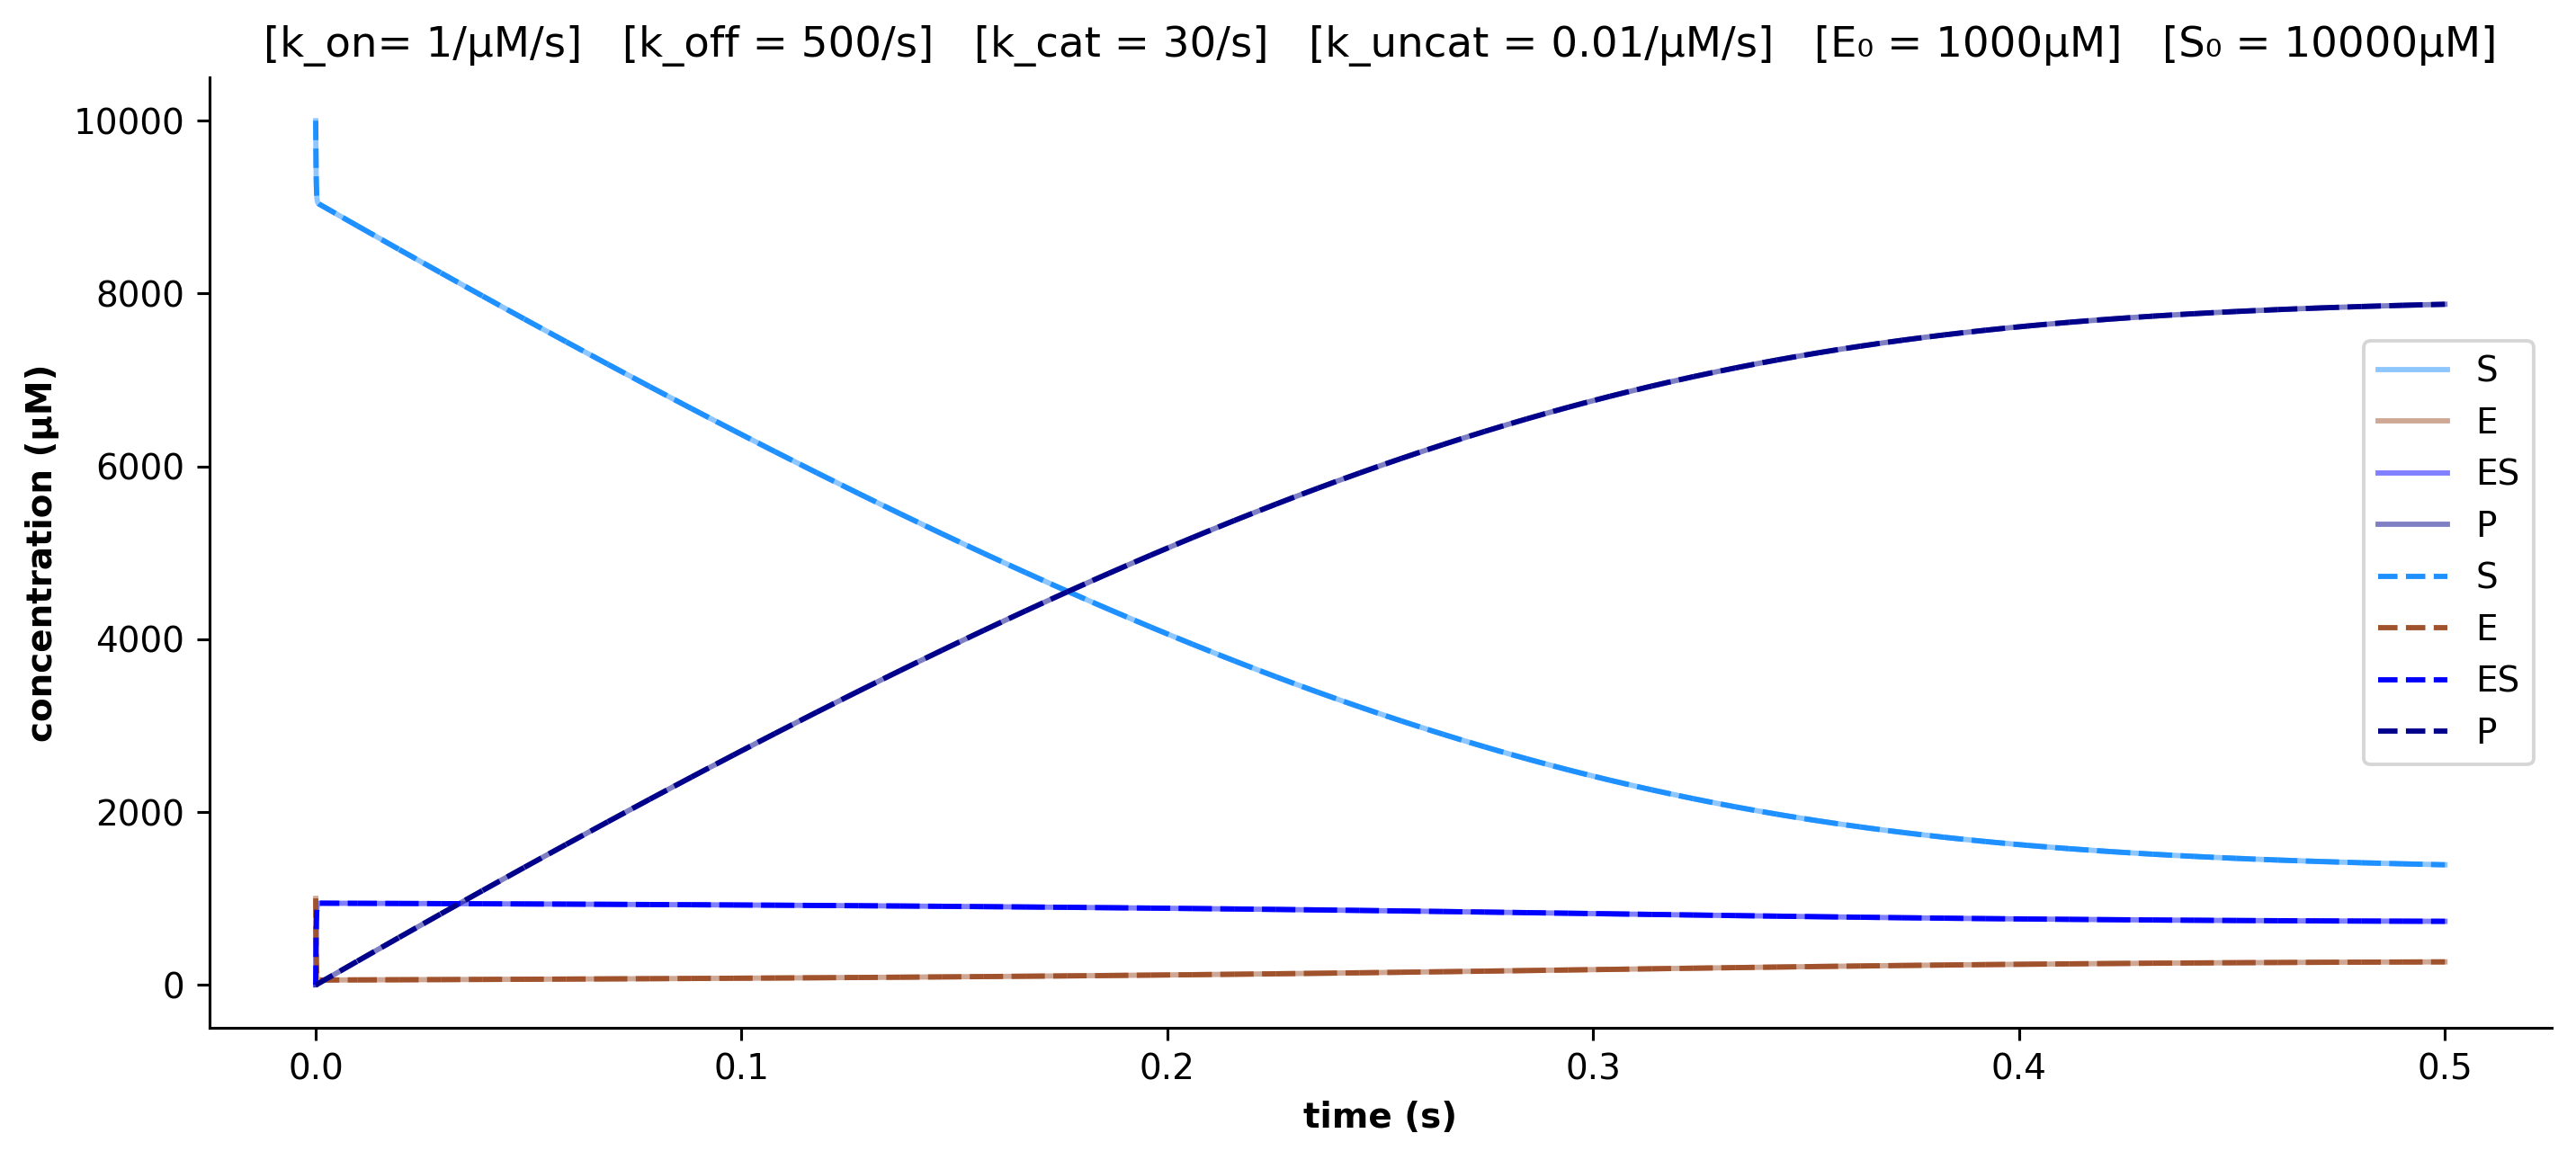

In [138]:
#collapse
# solve the system with both integrators, for default parameters
scipy_full_traj = scipy_full(dt, steps, default_kinetic_params, **default_initial_conditions)
euler_full_traj = euler_full(dt, steps, **default_kinetic_params, **default_initial_conditions)

ax = scipy_full_traj.plot.line(title=param_string(**default_initial_conditions, **default_kinetic_params), color=color(scipy_full_traj.columns), alpha=0.5)
euler_full_traj.plot.line(ax=ax, color=color(euler_full_traj.columns), linestyle='--')

fig_style(ax)

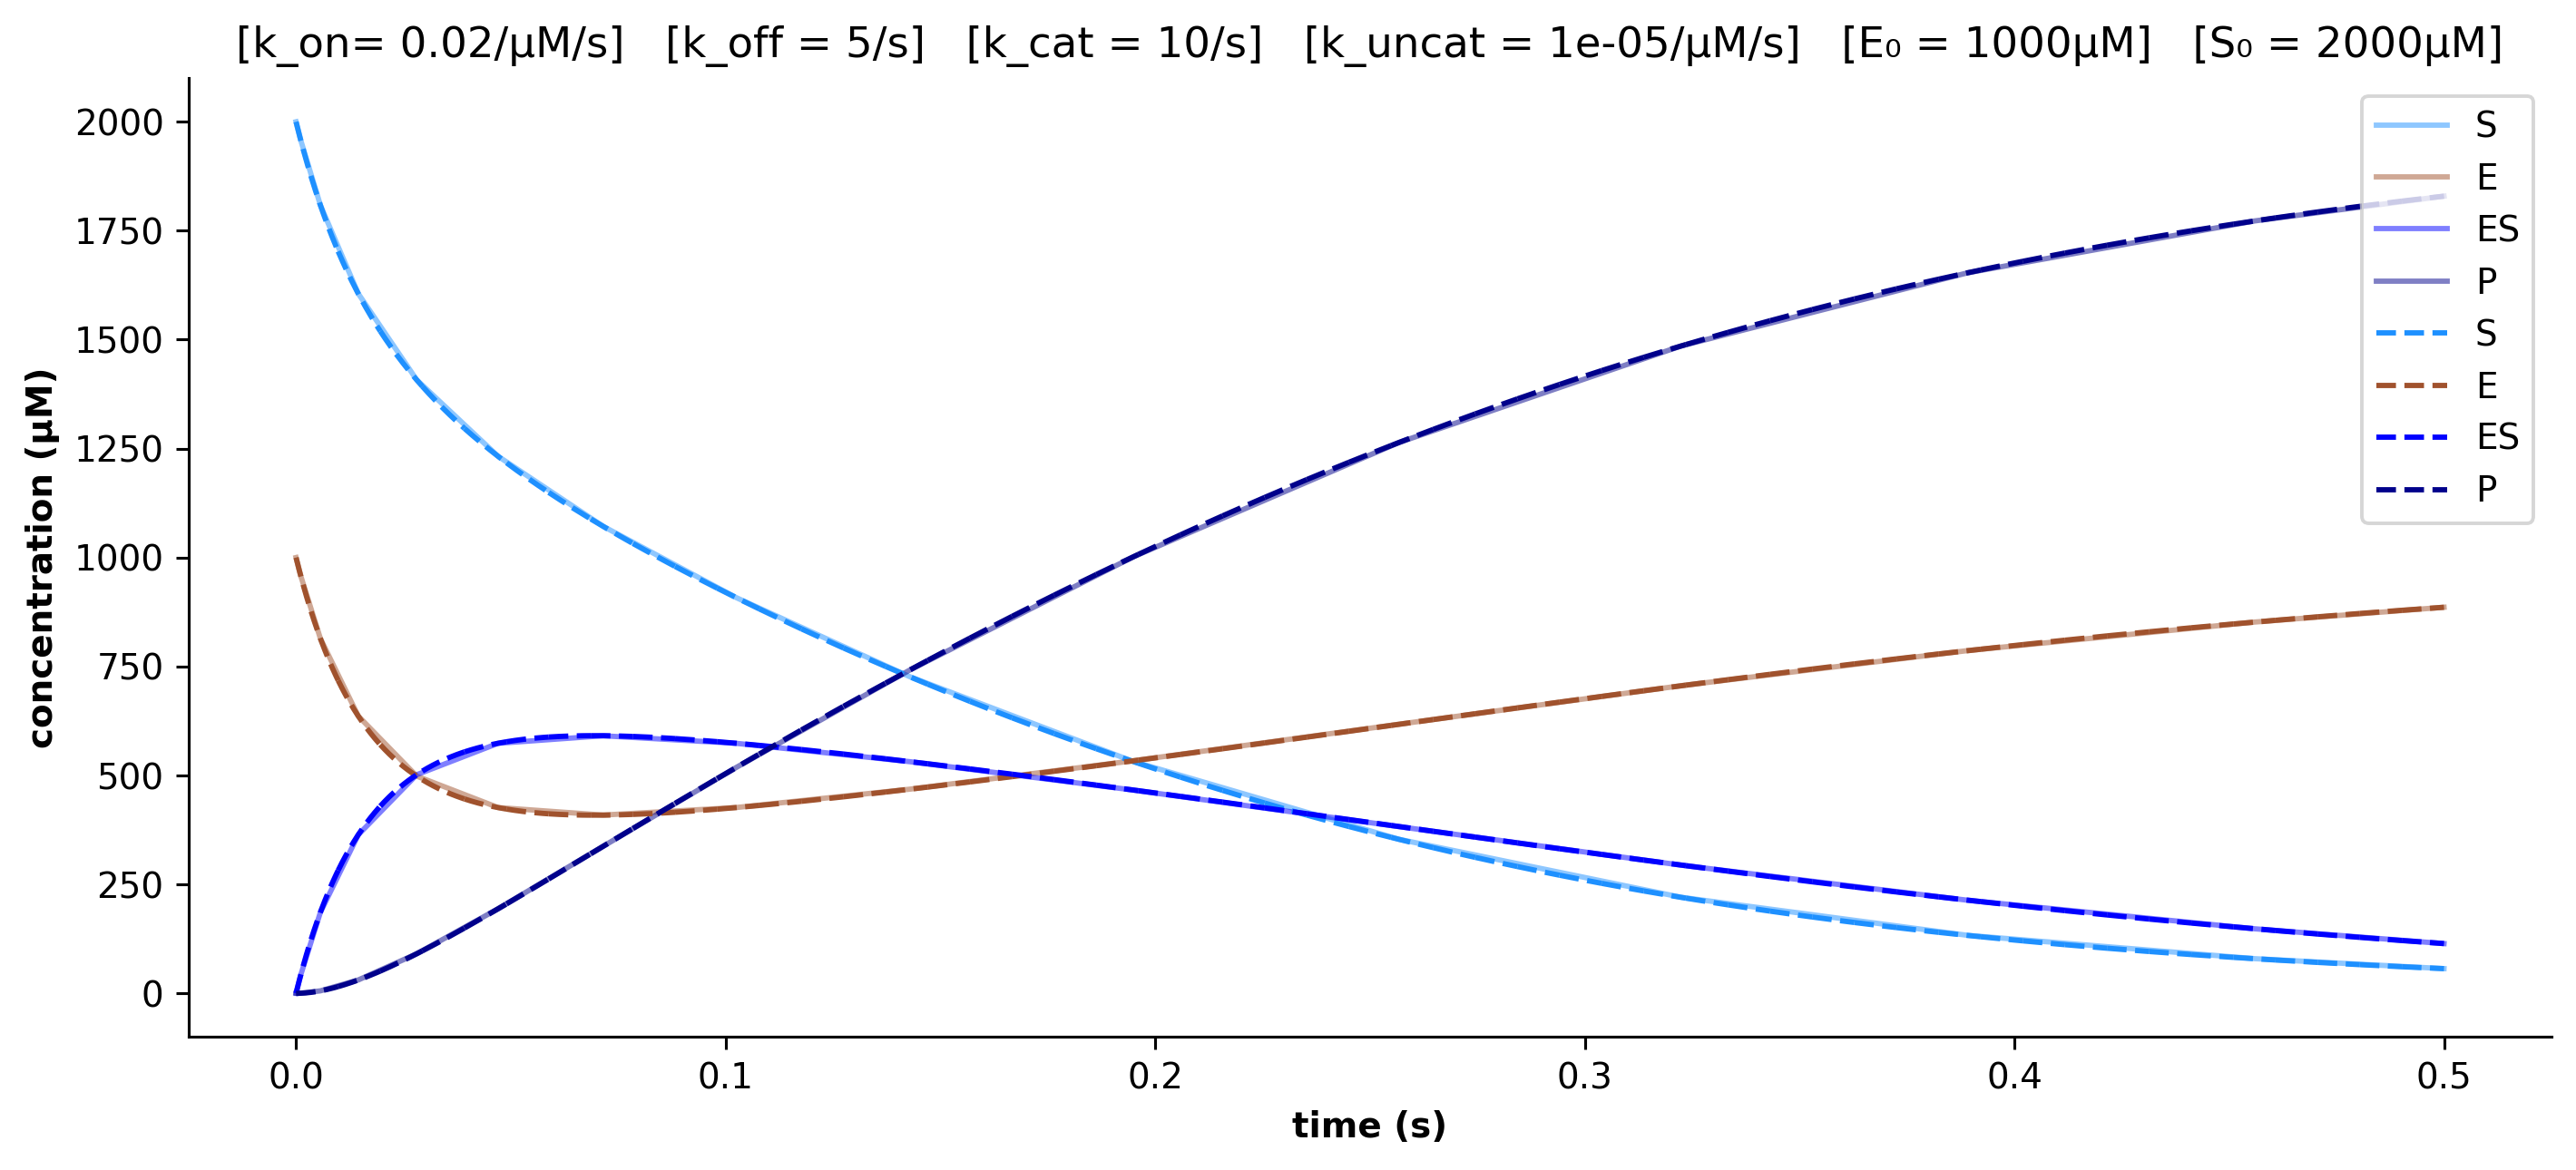

In [140]:
#collapse
# solve the system with both integrators, for unusual parameters
kinetic_params = {
    'k_on': 0.02, 
    'k_off': 5, 
    'k_cat': 10, 
    'k_uncat': 0.00001, 
}

kinetic_params['k_ms'] = k_ms(kinetic_params)
kinetic_params['k_mp'] = k_mp(kinetic_params)

import time
start = time.process_time()
scipy_full_traj = scipy_full(dt, steps, kinetic_params, **initital_conditions)
scipy_time = time.process_time() - start

start = time.process_time()
euler_full_traj = euler_full(dt, steps, **kinetic_params, **initital_conditions)
euler_time = time.process_time() - start

ax = scipy_full_traj.plot.line(title=param_string( **initital_conditions,**kinetic_params), color=color(scipy_full_traj.columns), alpha=0.5)
euler_full_traj.plot.line(ax=ax, color=color(euler_full_traj.columns), linestyle='--')

fig_style(ax)

The lack of deviation gives us confidence both integration techniques are accurate. Meanwhile,

In [145]:
f'our naïve code takes {round(euler_time, 2)}s, whereas the optimized scipy code takes {round(scipy_time, 4)}s to generate the same trajectory.'

'our naïve code takes 1.07s, whereas the optimized scipy code takes 0.0062s to generate the same trajectory.'

## 3. Inference

We've seen how different kinetic parameters result it different trajectories of the chemical system. We're interested in  the trajectory of a chemical system, and want to know the associated kinetic parameters. 

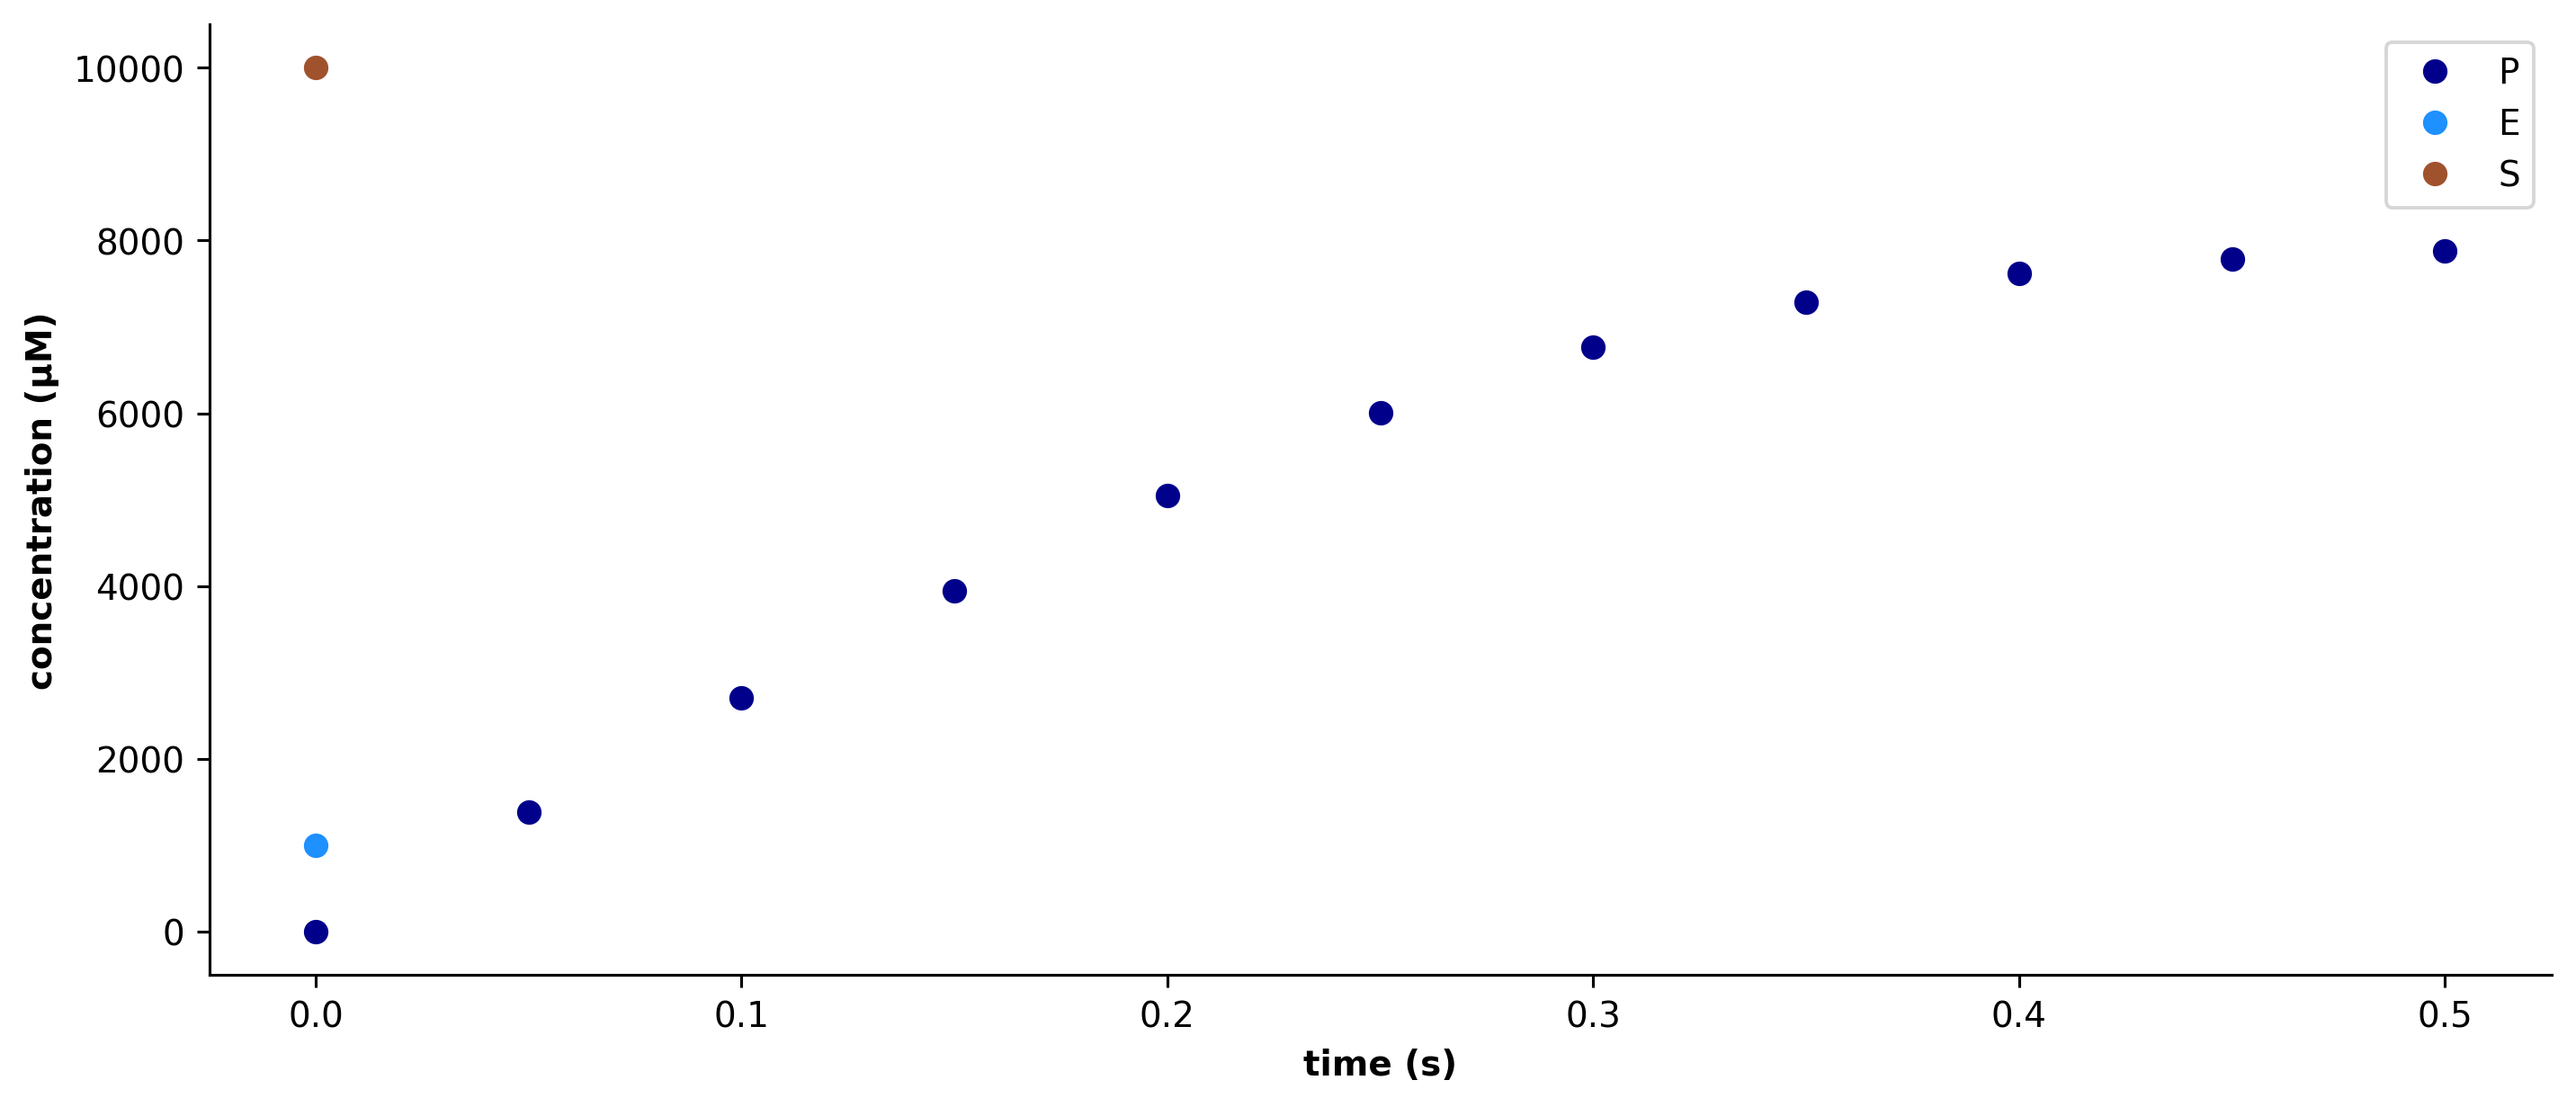

In [158]:
#collapse
# plot inverse problem setting
observations = default_traj_full.loc[np.arange(10+1)/20, 'P']

ax = observations.plot.line(marker='o', lw=0, color=color(['P']), legend=True)
default_traj_full.loc[0, ['E', 'S']].to_frame().T.plot.line(ax=ax, marker='o', lw=0, color=color(default_traj_full.columns), legend=True)

fig_style(ax)

One way to think about this is that there are two spaces: a parameter space and a trajectory space, and we want the inverse map from the trajectory space to the parameter space, at least well enough to determine what regions of the parameter space produce trajectories like the one we observe.

### 3.1 Bayesian Approach: Inference by Sampling 

> Note: We assume the reader is familiar with Bayesian Inference in more conventional settings

A Bayesian formulation of this inverse problem hinges on defining a likelihood. We define the likelihood as a gaussian of fixed variance around each observation. Together, they are a multivariate gaussian with no covariances (diagonal covariance matrix). 

We will run MCMC through parameter space, integrating samples 

The algorithm is as follows: 
1. Draw kinetic parameters from the proposal distribution. 
2. Integrate the system with the proposed kinetic parameters
3. Evaluate the likelihood, which measures the distance between the trajectory associated with the proposed parameters and the observed trajectory. 
4. Accept/Reject the proposal by a Metropolis-Hastings criterion.
5. Append the current kinetic parameters to the Markov Chain. 
5. Construct a proposal distribution around the current kinetic parameters.
6. Repeat



**Need to spend some time defining decent priors**

In [121]:
# kcat can range from 1e2 per second, to 1e6 per second, distribution is lognormal lets say. 
# if kon is 1 micromolar, and affinities can range from nanomolar to milimolar, then k_off must be between 1e-3 and 1e3. lognormal
# kon between 5e5 and 5e6 mean at 1e6, lognormal
# kuncat zero to 1e6, lognormal, mean at 1e2

# KM lies between 10^-1 and 10^-7 M

scipy.stats.lognorm?



Now let's use MCMC to get a posterior over $\kcat$, $\kuncat$, $K_{m,\mathrm{S}}$, and $K_{m,\mathrm{P}}$ (from which we can derive $\kon \,$ and $\koff$ ) using the Michaelis Menten Kinetics expression for $\dPdt$. The likelihood is a gaussian around the observed concentration of P, sampled densely in time. 

In [175]:
params = np.array([kms, kmp, k_cat, k_off])
prior_cov = np.eye(4) * params/3
prior = multivariate_normal(mean=params, cov=prior_cov)

observational_noise = 1
likelihood_dist = multivariate_normal(mean=obs.values, cov=np.eye(len(obs)) * observational_noise)

observed_idx = obs.index.astype(int)

def MH_MCMC(chain_length=1e3):

    zt = prior.rvs()
    ut = integrate_MM(zt)['P']
    πt = -likelihood_dist.logpdf(ut.loc[observed_idx].values) #- prior.logpdf(zt)
    
    cov = prior_cov
    i = 0
    accept_ratio = 0
    chain = []
    samples = []
    
    while i < chain_length: 

        ztp1 = np.clip(np.random.multivariate_normal(zt, cov), 0, None)
        utp1 = integrate_MM(ztp1)['P']
        πtp1 = -likelihood_dist.logpdf(utp1.loc[observed_idx].values) #- prior.logpdf(zt)
        
        if πtp1 - πt < -np.log(np.random.rand()): 
            zt, ut, πt = ztp1, utp1, πtp1
            accept_ratio += 1 

        chain.append(zt)
        samples.append(ut.values)

        i += 1
        
        if i % 1e2 == 0 and i > 0:
            cov = np.cov(np.array(chain), rowvar=False)
            print(i, end='\r')

    return pd.DataFrame(chain, columns=['kms', 'kmp', 'k_cat', 'k_off']), pd.DataFrame(samples), accept_ratio/chain_length, cov


In [176]:
chain, samples, accept_ratio, cov = MH_MCMC()

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


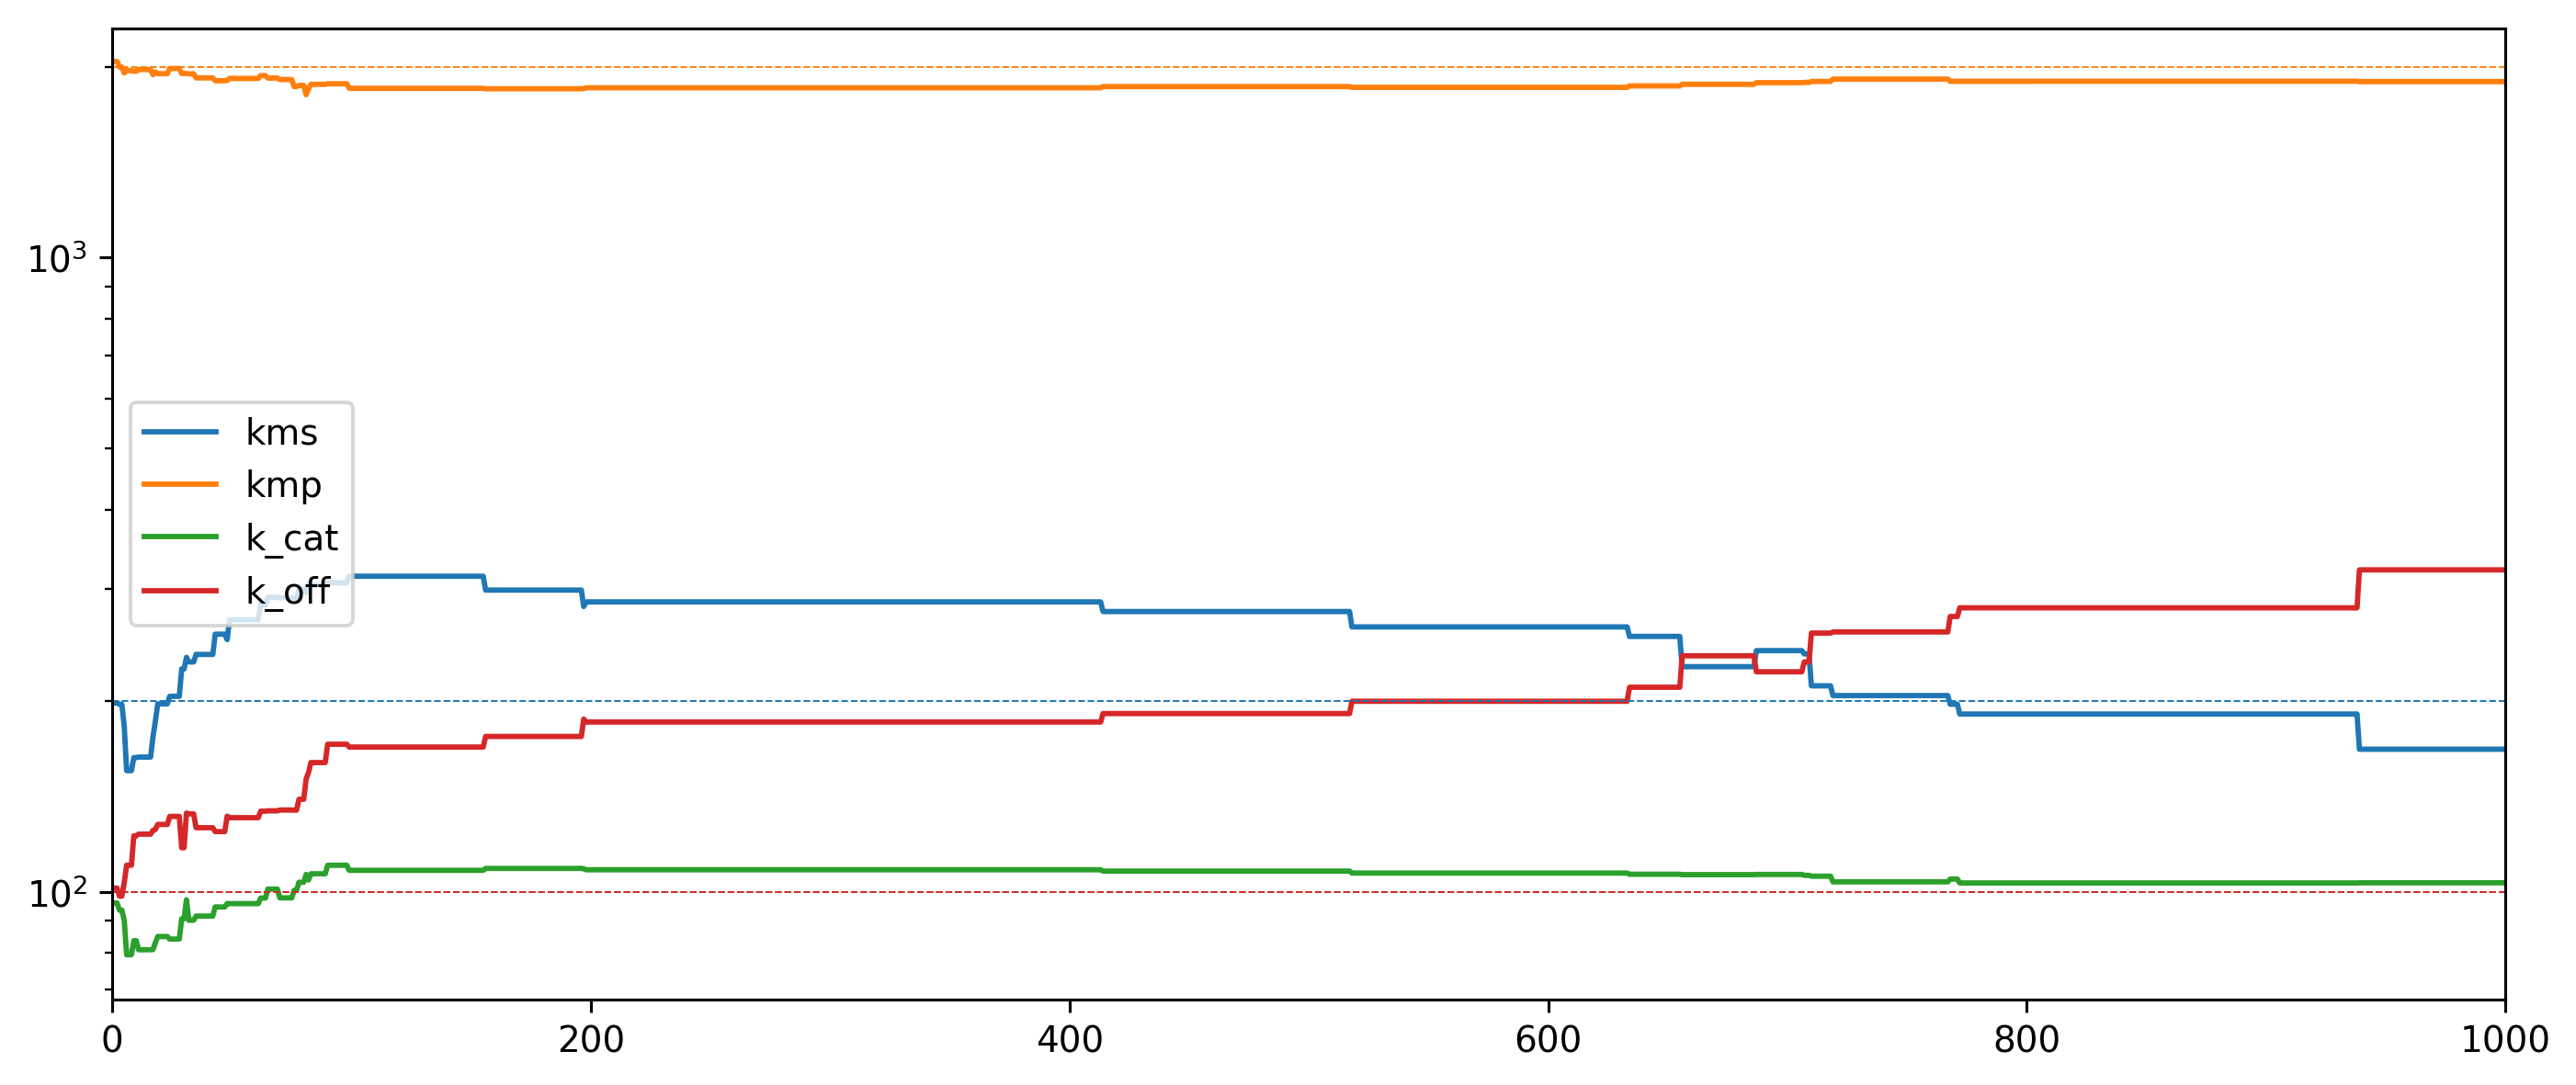

In [177]:
ax = chain.plot.line(ylim=(0, 2300), xlim=(0,1000), logy=True)

for i, param in enumerate(params): ax.axhline(param, lw=0.5, color=cmap(i), linestyle='--') 

In [178]:
params

array([ 200., 2000.,  100.,  100.])

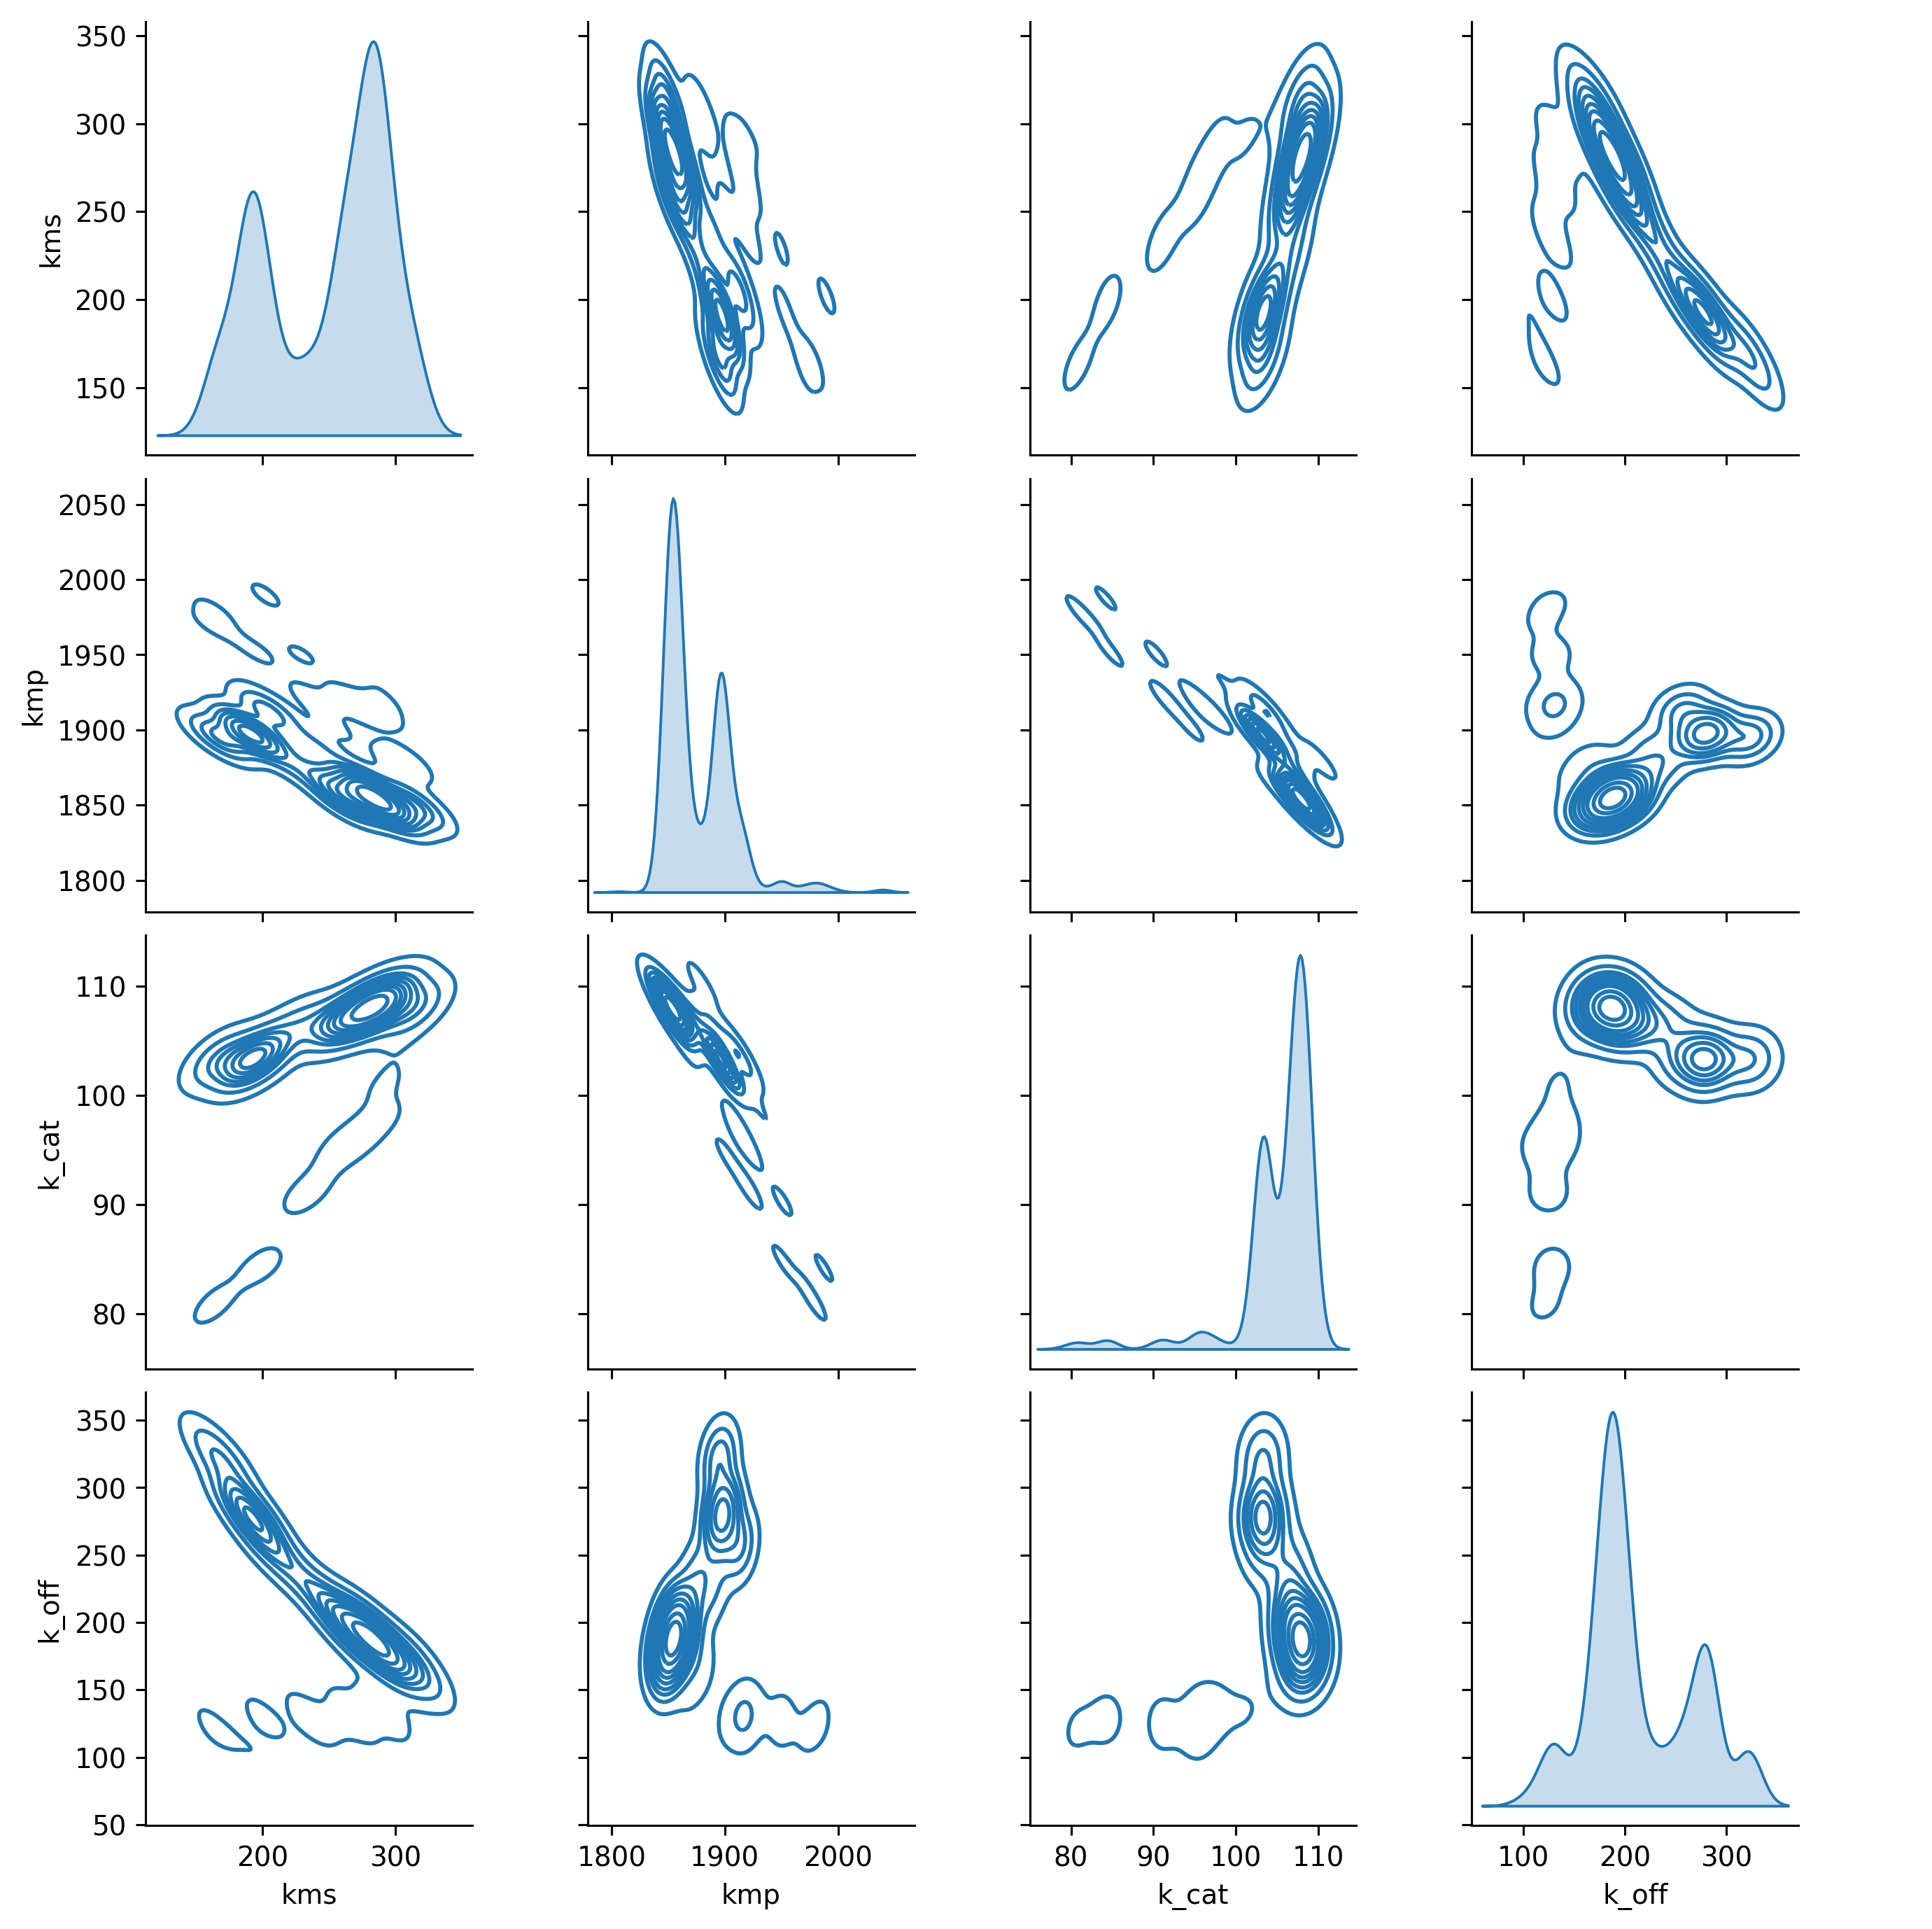

In [179]:
sns.pairplot(chain, kind="kde")

In [180]:
accept_ratio

0.04

In [181]:
pd.DataFrame(cov)

,0,1,2,3
0,2098.532183,-997.484455,123.922103,-1823.662515
1,-997.484455,873.417648,-123.266991,331.330642
2,123.922103,-123.266991,23.117602,14.054959
3,-1823.662515,331.330642,14.054959,2684.146271


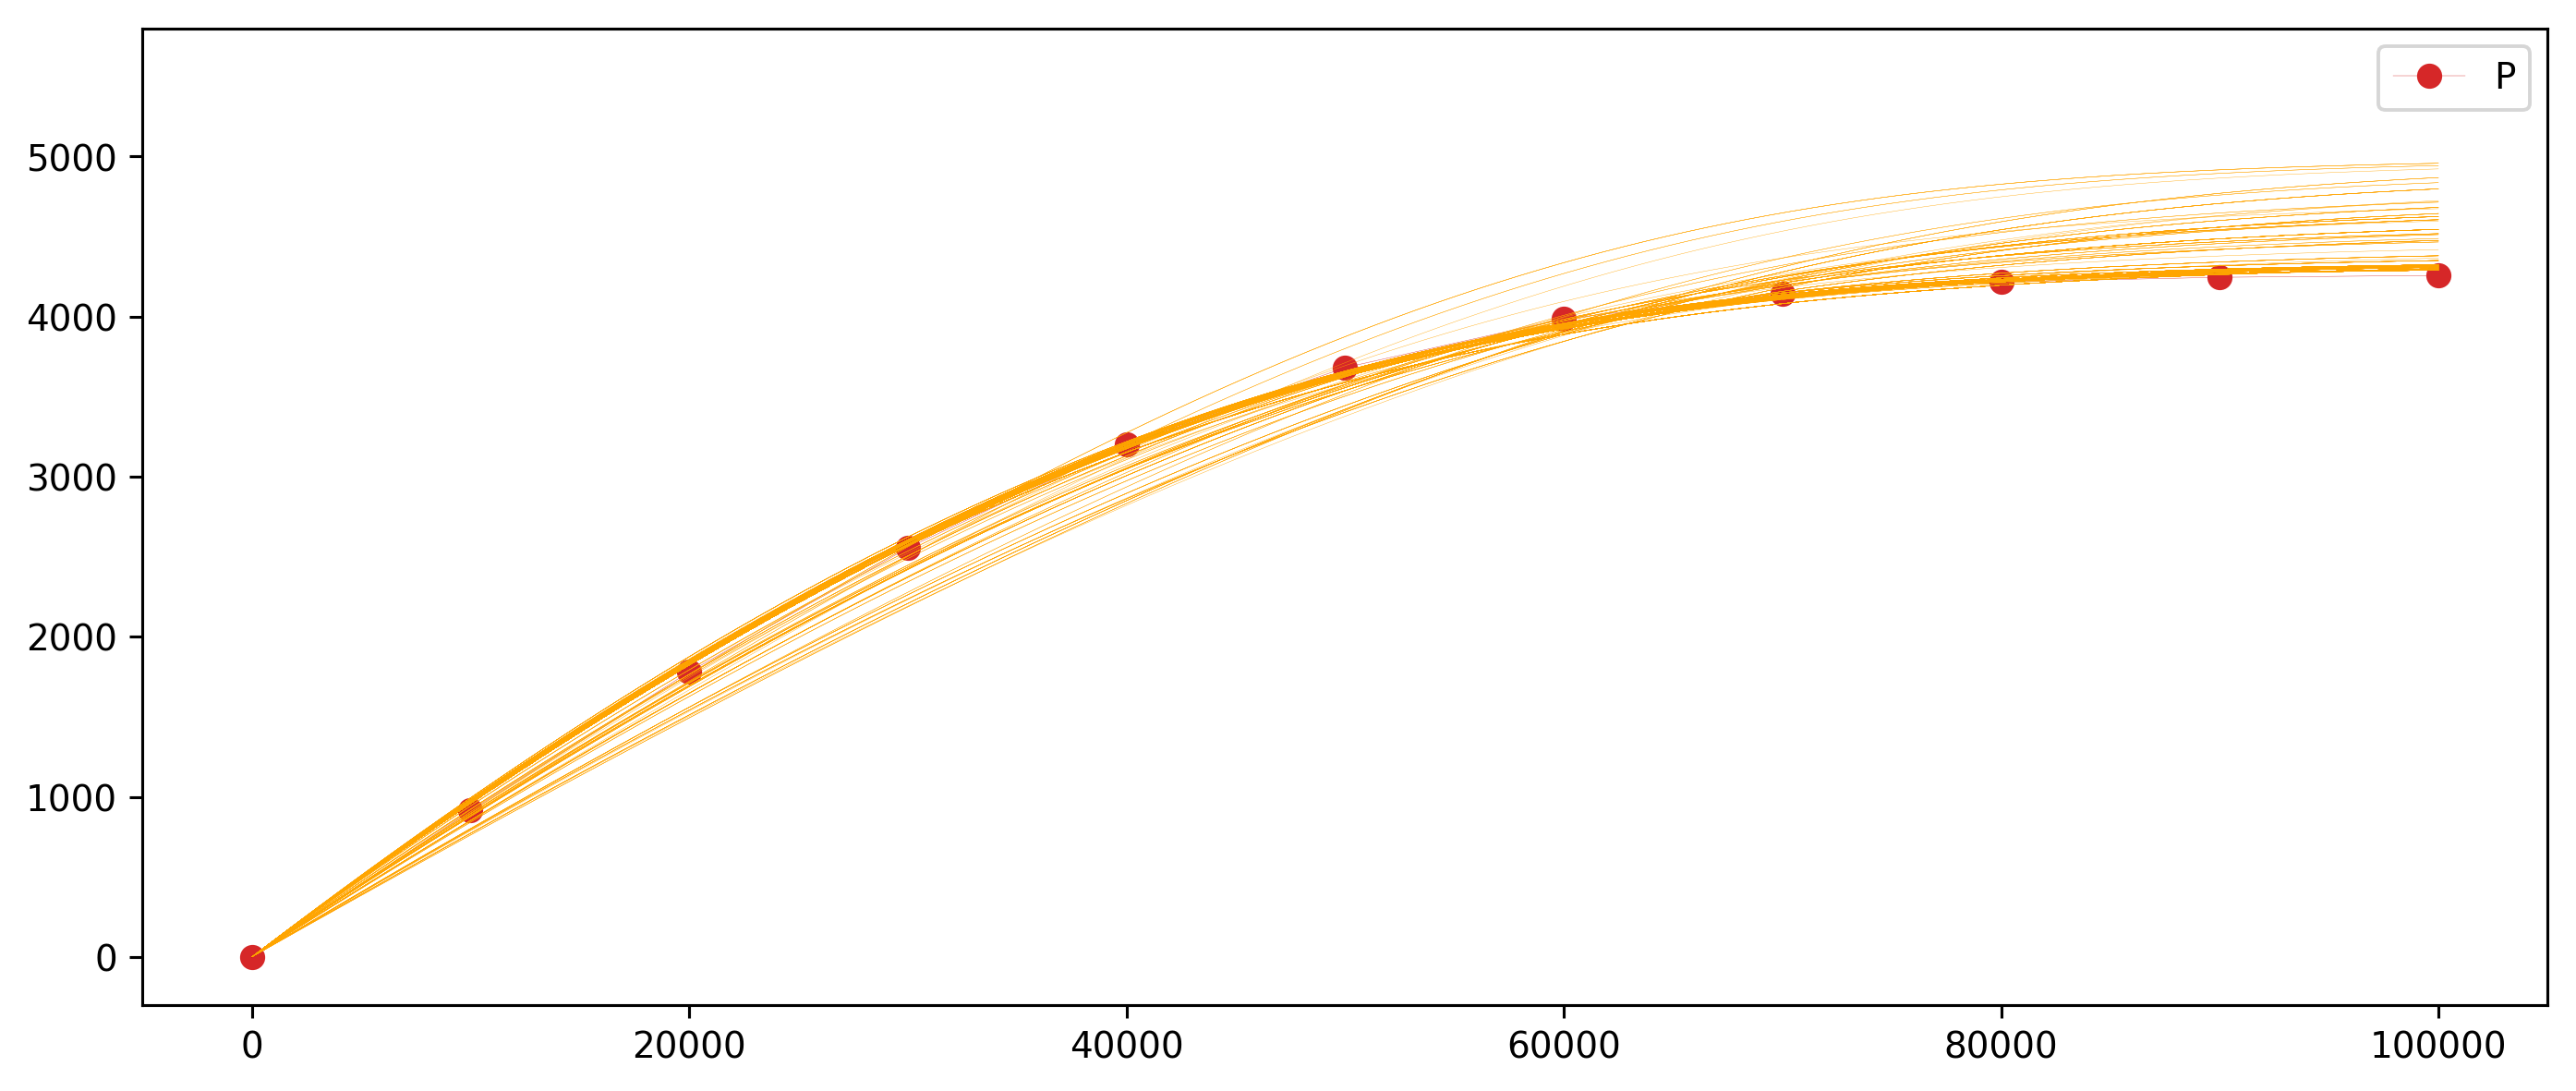

In [182]:
ax = obs.plot.line(marker='o', lw=0.1, color=cmap(3), ylim=(-300, 5800), legend=True)
samples.loc[-100:][samples.columns[::50]].T.plot.line(color='orange', lw=0.1, ax=ax, legend=False)

In [174]:
chain.to_hdf('chain.hdf', 'chain1')
samples.to_hdf('chain.hdf', 'samples1')

### 3.2 Frequentist Approach: Inference by Optimization

# 4. Conclusions

# 5. References

- [A Database of Thermodynamic Quantities for the Reactions of Glycolysis and the Tricarboxylic Acid Cycle](https://pubs.acs.org/doi/10.1021/jp911381p)

- [A database of thermodynamic properties of the reactions of glycolysis, the tricarboxylic acid cycle, and the
pentose phosphate pathway](https://academic.oup.com/database/article/doi/10.1093/database/bar005/462082)

- [Thermodynamics of Glycolysis](https://chem.libretexts.org/Bookshelves/General_Chemistry/Book%3A_Structure_and_Reactivity_in_Organic_Biological_and_Inorganic_Chemistry_(Schaller)/III%3A_Reactivity_in_Organic_Biological_and_Inorganic_Chemistry_1/08%3A_Mechanisms_of_Glycolysis/8.08%3A_Thermodynamics_of_Glycolysis)

- [BKMS-React database entry for glycolysis](http://bkms-react.tu-bs.de/pathway.php?pw_id=pw_glycolysis&ecno=1.2.1.12&id=50)

- [Bistability in Glycolysis Pathway as a Physiological Switch in Energy Metabolism](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0098756#pone.0098756.s012)

- [Determination of the rate of hexokinase-glucose dissociation by the isotope-trapping method](https://www.jbc.org/content/249/16/5163.full.pdf)

- [Quantitative Fundamentals of Molecular and Cellular Bioengineering](https://mitpress.mit.edu/books/quantitative-fundamentals-molecular-and-cellular-bioengineering)